<a href="https://colab.research.google.com/github/adilabduakhanov/Colab-Projects/blob/main/Quality_control_of_the_sales_department.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Схема проекта

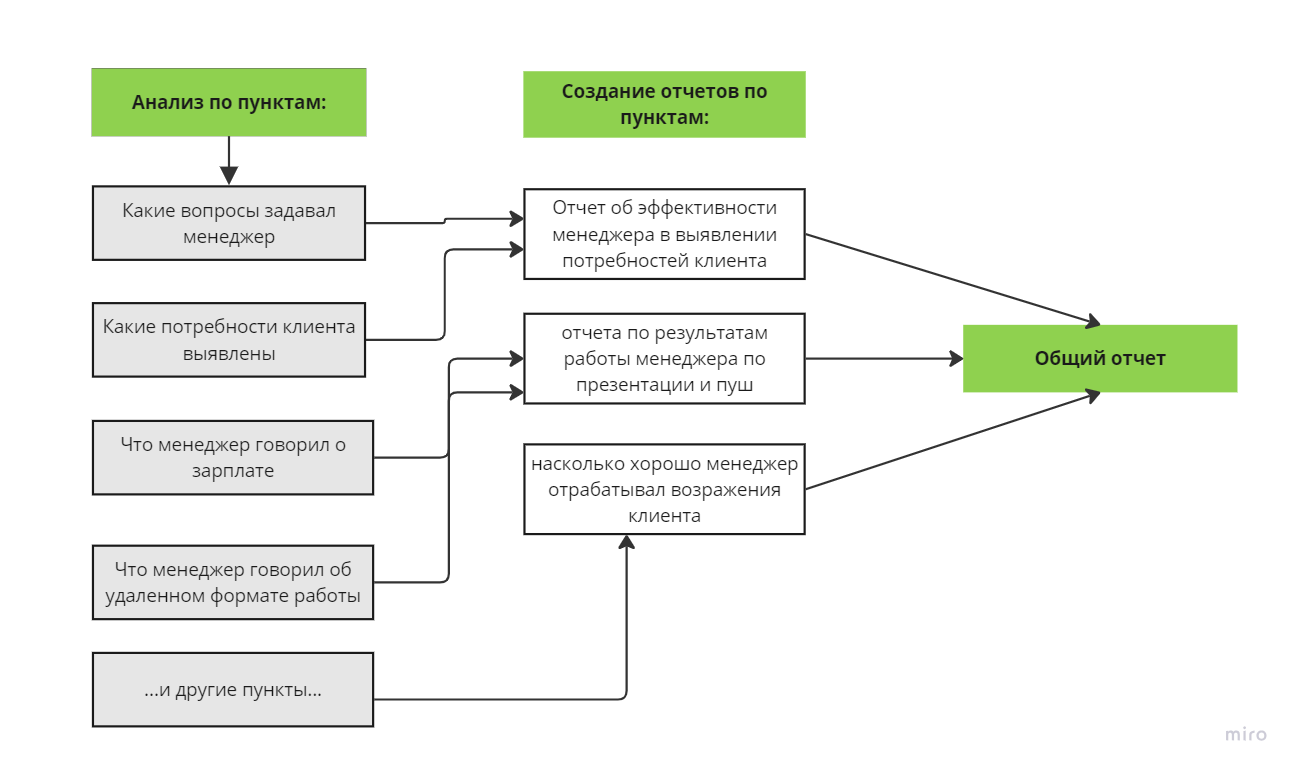

In [ ]:
#@title Установка библиотек и импорт модулей
!pip install -q openai==1.57.0 langchain==0.3.9 langchain_core==0.3.21 langchain_community==0.3.9 \
langchain-openai==0.2.11 faiss-cpu==1.9.0.post1 tiktoken==0.8.0


import os
from google.colab import userdata
from langchain.text_splitter import CharacterTextSplitter
import tiktoken
import textwrap
from google.colab import output
from langchain.docstore.document import Document
from langchain.vectorstores import FAISS
from openai import OpenAI
from langchain_openai import OpenAIEmbeddings
import re
import json
import pickle


# Чтение ключа OPENAI_API_KEY
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')

In [ ]:
#@title Объявляем общие функции

# Функция для чтения файла
def load_document_text(file_path) -> str:
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    return text


# Запись словаря на диск в '/content/' в бинарном режиме
def save_dict_data(dict_data):
    with open('/content/dict_data.pkl', 'wb') as file:
        pickle.dump(dict_data, file)


# Загрузка словаря с диска из '/content/' для чтения в бинарном режиме
def load_dict_data():
    with open('/content/dict_data.pkl', 'rb') as file:
        return pickle.load(file)


# Функция для форматирования текста по абзацам
def format_text(text, width=120):
    # Разделяем текст на абзацы
    paragraphs = text.split('\n')
    # Форматируем каждый абзац отдельно
    formatted_paragraphs = []
    for paragraph in paragraphs:
        # Используем textwrap.fill для форматирования абзаца, чтобы длина строки не превышала width
        formatted_paragraph = textwrap.fill(paragraph, width)
        formatted_paragraphs.append(formatted_paragraph)
    # Объединяем абзацы с символом новой строки
    return '\n'.join(formatted_paragraphs)


# Функция возвращает количество токенов в строке в зависимости от используемой модели
def num_tokens_from_string(string: str, model='gpt-4o-mini') -> int:
    # Получаем имя кодировки для указанной модели
    encoding_name = tiktoken.encoding_for_model(model).name
    # Получаем объект кодировки на основе имени кодировки
    encoding = tiktoken.get_encoding(encoding_name)
    # Кодируем строку и вычисляем количество токенов
    num_tokens = len(encoding.encode(string))
    # Возвращаем количество токенов
    return num_tokens + 10


# Формируем чанки из текста (CharacterTextSplitter) и создаем векторную базу
def create_db_index(text: str,
                    chunk_size=2048,   # Ограничение к-ва символов в чанке
                    chunk_overlap=0):  # к-во символов перекрытия в чанке
    splitter = CharacterTextSplitter(chunk_size=chunk_size,
                                     chunk_overlap=chunk_overlap,
                                     separator="\n") # по переносу строки
    text_chunks = splitter.split_text(text) # список текстовых чанков
    print(f'Количество чанков: {len(text_chunks)}.\n')
    return FAISS.from_texts(text_chunks, OpenAIEmbeddings())



"""Функция answer_index выполняет поиск по векторной базе для получения k
наиболее релевантных документов по заданной теме, формирует
сообщения для модели и генерирует ответ с использованием OpenAI API """
def answer_index(system,        # инструкция system
                 instructions,  # инструкция для формирования роли user
                 topic_phrase,  # контент для поиска чанков в векторной базе
                 db_index,      # индексная база
                 k,             # количество релевантных чанков
                 example='',    # пример ответа
                 format='text',       # формат примера ответа 'json' или 'text'
                 model='gpt-4o-mini', # модель GPT
                 temp=0.1):     # температура
    docs = db_index.similarity_search_with_score(topic_phrase, k=k)
    response_format = None
    message_content = '\n '.join([f'Отрывок №{i+1}\n{doc[0].page_content}' for i, doc in enumerate(docs)])
    messages = [{"role": "system", "content": system}]
    if example != '':
        messages.append({"role": "user", "content": 'Ответь на вопрос' + ' и верни ответ в формате JSON' if format == 'json' else ''})
        messages.append({"role": "assistant", "content": example})
        if format == 'json': response_format = {'type': 'json_object'}
    messages.append({"role": "user", "content": f"{instructions}\n\nТексты для анализа:\n{message_content}"})
    completion = OpenAI().chat.completions.create(model=model,
                                                  messages=messages,
                                                  temperature=temp,
                                                  response_format=response_format)
    return completion.choices[0].message.content


"""Функция формирует сообщения для модели на основе документа, инструкций и результатов
анализа, затем генерирует ответ с использованием OpenAI API """
def answer_user_question_from_answer(system,                 # инструкция system
                                     instructions,           # инструкция для формирования роли user
                                     answers_content,        # результаты предыдущего анализа
                                     temp=0.1,               # температура
                                     model='gpt-4o-mini'):   # модель GPT
    messages = [{"role": "system", "content": system},
                {"role": "user", "content": f"{instructions}\n\nИнформация для анализа:\n{answers_content}"}]
    completion = OpenAI().chat.completions.create(model=model, messages=messages, temperature=temp)
    return completion.choices[0].message.content


##Диалог

https://disk.yandex.ru/d/IqOQeMnvd6YSKg  ссылка на диалоги менеджера и клиента.



Далее следует код, предназначенный для загрузки и объединения текстовых файлов с Яндекс Диска, содержащих транскрибированные диалоги из аудиозаписей Zoom: в каждой папке 3 текстовых файла: то, что говорил клиент, то, что говорил менеджер и совместный текст.

In [ ]:
#@title Ссылка с Яндекс диска c текстовыми файлами диалога

folder_url_yadisk = "https://disk.yandex.ru/d/IqOQeMnvd6YSKg" # Ссылка на основную папку на Яндекс Диске
full_url = f'https://getfile.dokpub.com/yandex/get/{folder_url_yadisk}' # Построение полной ссылки для загрузки
temp_dir = 'temp' # Название временной директории


# Функция для загрузки содержимого по URL
def download_from_url(full_url, temp_dir):
  # Создание временной директории, если она не существует
  if not os.path.exists(temp_dir):
    os.mkdir(temp_dir)
  # Запись URL во временный файл
  with open("temp/tmp.txt", "w") as f:
      f.write(full_url)
  try:
    # Удаление существующих файлов и папок, если они существуют
    try:
        os.remove("temp.zip")
        !rm -R '/content/Audio Record/'
    except:
        pass
    # Загрузка и распаковка архива
    !wget -O temp.zip -i temp/tmp.txt
    !unzip '/content/temp.zip' -d '/content/'
    output.clear()
    print('Файлы успешно загружены!')
  except Exception as e:
    print("Ошибка: ", e)


# Загрузка файлов
download_from_url(full_url, temp_dir)

Файлы успешно загружены!


In [ ]:
#@title Подсчет токенов. Создание векторных баз

text_dialog = load_document_text(r'/content/Audio Record/merged_dialogue.txt')
print('Токенов в Диалог: ', num_tokens_from_string(text_dialog))
dialog_db_index = create_db_index(text_dialog, 2048, 0)

text_client = load_document_text(r'/content/Audio Record/client_recogn.txt')
print('Токенов в Client: ', num_tokens_from_string(text_client))
client_db_index = create_db_index(text_client, 2048, 0)

text_manager = load_document_text(r'/content/Audio Record/manager_recogn.txt')
print('Токенов в Manager: ', num_tokens_from_string(text_manager))
manager_db_index = create_db_index(text_manager, 2048, 0)


# Функция выбора векторной базы по зазванию
def get_db_index(name):
    if name == 'Диалог': return dialog_db_index
    elif name == 'Client': return client_db_index
    elif name == 'Manager': return manager_db_index

Токенов в Диалог:  7110
Количество чанков: 15.

Токенов в Client:  2097
Количество чанков: 4.

Токенов в Manager:  5009
Количество чанков: 11.



#B2B или B2C

In [ ]:
#@title 1. B2B или B2C

system_prompt = """Ты анализируешь текст, в котором клиент обратился в 'Университет искусственного
интеллекта' для покупки курсов обучения по искусственному интеллекту и программированию. Твоя задача
точно определить, является ли клиент b2b или b2c. # Всегда учитывай, что 'b2c' - это человек
который ищет курсы для себя чтобы получить новую работу / заработать большую зарплату / улучшить
свои навыки или развиться в IT-сфере / когда человек говорит о личном интересе к нейронным сетям /
когда он хочет создать проект для себя/стажировки/гарантия трудоустройства/смена деятельности / когда
вы понимаете что разговор идет о личных интересах клиента. # Всегда учитывай, что 'b2b' - это когда
есть фразы в тексте указывающим на то, что клиент явно хочет обучить своих сотрудников / создать проект
для своей компании / с целью развития услуг / увеличения доходов / когда предприниматель или руководитель
компании обращается в компанию /  когда ты слышишь что разговор идет о интересах компании. Ты знаешь
на 100% что фразы о нейронных сетях / разработке / программировании / датасетов / аналитика / анализирования /
инстуственном интеллекте / алгоритмы / создание проектов / разработка игр - НИКОГДА НЕ ОПРЕДЕЛЯЕТ
является ли этот клиент b2b или b2c. Ты всегда пишешь не равные проценты дления между b2b и b2c.
Ты всегда строго следуешь порядку отчета."""

instructions = """Проанализируй все тексты, определи является ли клиент b2b или b2c согласно тому
что ты знаешь, и напишите только вывод: 1. 'b2c: % вероятность, что это b2c'; 2) 'b2b: % вероятность,
что это b2b'; 3) 'подробное описание до 200 символов, объясняющее, почему это b2b или b2c'. Затем с
новой строки сделай свой вывод: 'Клиент: B2B' или 'Клиент B2C' """

topicphrase = "проект, себя, развиваться, создать, обучиться, навки, знания, трудоустройство"

out = {} # Словарь для результатов анализа

db_index = get_db_index('Client')
num_fragment = 5
out['B2_1'] = answer_index(system_prompt, instructions, topicphrase, db_index, num_fragment)

# получаем тип клиента
match = re.search(r'Клиент:\s*(.*)', out['B2_1'])  # Ищем строку, которая начинается с "Клиент:" и захватываем всё, что идет после двоеточия
if match:  # Проверяем, нашелся ли соответствующий шаблон в тексте
  out['B2_2'] = match.group(1)  # Если найдено, извлекаем захваченное значение (тип клиента) и сохраняем в словаре `out` под ключом 'B2_2'
else:  # Если шаблон не найден
  out['B2_2'] = 'Тип клиента не определен!'


print(f"\n{format_text(out['B2_1'])}")
print(f"\nТип клиента: {out['B2_2']}")
save_dict_data(out)


1. 'b2c: 90% вероятность, что это b2c';
2. 'b2b: 10% вероятность, что это b2b';
3. 'Клиент говорит о личных интересах, желании обучиться и улучшить свои навыки для поиска работы и повышения дохода,
что указывает на b2c.'

Клиент: B2C

Тип клиента: B2C


#B2C

## Выявление





In [ ]:
#@title 1\. Вопросы менеджера
db_index = get_db_index('Manager')
num_fragment = 10

system_prompt = """Ты умеешь распознавать вопросительные фразы / вопросы в тексте."""

instructions = """Проанализируй текст и найди ВСЕ фразы, которые являются вопросительными.
Далее, напиши список из цитат вопросительных фраз / вопросов + укажи время в тексте,
где ты нашел вопросительную фразу / вопрос. Тебе запрещено в списке писать одинаковые вопросы."""

topicphrase = """как , сколько, верно, скажите, хотите, знаете, когда, какой, какая, что, почему,
зачем, куда, откуда, чей, кто, где, чем, ?"""

out['identification_1'] = answer_index(system_prompt, instructions, topicphrase, db_index, num_fragment)

print(format_text(out['identification_1']))
save_dict_data(out)

Вот список всех вопросительных фраз / вопросов из предоставленных текстов, с указанием времени:

1. **19:19** - "Остались ли возможно по нему какие-то вопросы уточняющие?"
2. **19:19** - "Что хочется узнать?"
3. **20:24** - "Может слышали?"
4. **27:15** - "Что он буде за обучение платить или вы будете оплачивать его?"
5. **28:08** - "Во это все вам заходит?"
6. **28:35** - "Вам как удобно вообще оплачивать?"
7. **20:01** - "Вы же наверное сами знаете, там, не знаю, оформляли когда-нибудь рассрочку?"
8. **29:45** - "Договорились?"
9. **00:14** - "Вы уже знаете как меня зовут?"
10. **00:51** - "Откуда к нам обращаетесь?"
11. **00:56** - "Где живете?"
12. **1:06** - "А как давно работаете и что именно продаете?"
13. **1:21** - "Давно работаете?"
14. **1:29** - "Давно именно в психологии в компании работаете?"
15. **1:38** - "Вот вам было бы ближе что именно сейчас?"
16. **1:58** - "Почему решили поменять спектр и вообще в другую сторону?"
17. **2:36** - "Как давно уже устаете и приходите 

In [ ]:
#@title 1.1. Отчет по выявлению

system_prompt = """Ты профессионал в умении задавать вопросы клиенту для выявления потребностей клиента.
Тебе даны вопросы от менеджера к клиенту, которые выявлены в тексте общения. Твоя задача - найти вопросы
которые позволяют лучше понять клиента и выявить его потребности."""

instructions = """Проанализируй вопросы и составь список только из тех фраз, которые являются вопросами."""

answer = out['identification_1'] + '\n'

out['identification_1_1'] = answer_user_question_from_answer(system_prompt, instructions, answer)

print(format_text(out['identification_1_1']))
save_dict_data(out)

Вот список вопросов, выделенных из предоставленных текстов:

1. "Остались ли возможно по нему какие-то вопросы уточняющие?"
2. "Что хочется узнать?"
3. "Может слышали?"
4. "Что он буде за обучение платить или вы будете оплачивать его?"
5. "Во это все вам заходит?"
6. "Вам как удобно вообще оплачивать?"
7. "Вы же наверное сами знаете, там, не знаю, оформляли когда-нибудь рассрочку?"
8. "Договорились?"
9. "Вы уже знаете как меня зовут?"
10. "Откуда к нам обращаетесь?"
11. "Где живете?"
12. "А как давно работаете и что именно продаете?"
13. "Давно работаете?"
14. "Давно именно в психологии в компании работаете?"
15. "Вот вам было бы ближе что именно сейчас?"
16. "Почему решили поменять спектр и вообще в другую сторону?"
17. "Как давно уже устаете и приходите к тому, что для вас это энергозатратная работа?"
18. "Как с этим справляетесь?"
19. "Слушайте, слышу вас. Ну, я так правильно понимаю, что была бы идеальна такая работа, где минимизирован, можно
сказать, человеческий фактор - общение,

In [ ]:
#@title 1.2. Отчет по выявлению

system_prompt = """Ты профессионал в умении задавать вопросы клиенту при продаже курсов обучения.
Результат анализа - вопросы bp текстf общения клиента и менеджера. Твоя задача - найти вопросы в
которые позволяют лучше понять клиента и выявить его потребности.  Ты определяешь качество заданных
вопросов от 100% до 0% по градации: - 100% - если в результате анализа из общего числа вопросов ты
нашел более восьми штук вопросов которые позволяют качественно выявить потребности желания и боли
клиента и лучше узнать клиента,  - 0% - если в результате анализа из общего числа вопросов ты нашел
ноль штук вопросов которые позволяют качественно выявить потребности желания и боли клиента и лучше
узнать клиента. Не важно какое количество вопросов в результате анализа, цифру оценки качества надо
писать строго ориентируясь на градацию. Ты абсолютно всегда на 100% соблюдаешь порядок отчетов!"""

instructions = """Напиши: #01 "quality": общая оценка качества вопросов найденных в тексте от 0% до
100% написанная строго по градации. #02 Проанализируй результат и общими словами опиши, почему ты
поставил такую оценку по первому отчету. #03 "count": напиши количество только тех вопросов в списке,
которые помогают выявить потребность боли и желания клиента. Первый, второй и третий пункты отдели
друг от друга."""

answer = out['identification_1_1'] + '\n'

out['identification_1_2'] = answer_user_question_from_answer(system_prompt, instructions, answer)

print(format_text(out['identification_1_2']))
save_dict_data(out)

#01 "quality": 100%

#02 Проанализировав список вопросов, я пришел к выводу, что все они направлены на выявление потребностей, желаний и
болей клиента. Вопросы касаются различных аспектов жизни и работы клиента, его опыта, мотивации и предпочтений. Это
позволяет менеджеру глубже понять, что именно ищет клиент, какие у него есть проблемы и как курс может помочь в их
решении. Вопросы охватывают широкий спектр тем, что свидетельствует о высоком качестве взаимодействия.

#03 "count": 46


In [ ]:
#@title 2\. Потребности. Выявление конкретных указанных нами потребностей.

system_prompt = """Ты превосходно разбираешься в общении между менеджером по продажам и клиентом.
Менеджер по продажам работает в компании, которая продает обучение программированию на Python и
искусственному интеллекту для нейронных сетей. Перед тобой текст, содержащий только ответы и
заявления клиента. Твоя основная задача - определить потребности клиента из предложенного списка.
Ты всегда очень точно следуете порядку отчета. Ты не исползуешь MarkDown."""

instructions = """Проанализируй весь текст на предмет наличия потребностей и напиши отчет по всем
параметрам:
- Трудоустройство: Укажи, есть ли во всех текстах потребность в трудоустройстве в формате:
"Трудоустройство: "да/нет" + цитаты, упомянутые в текстах.
- Высокая зарплата: Укажите, есть ли во всех текстах потребность в высокой зарплате в формате:
"Высокая зарплата: "да/нет" + цитаты, упомянутые в текстах.
- Удаленная работа: Укажите, есть ли во всех текстах потребность в удаленной работе в формате:
"Удаленная работа: "да/нет" + цитаты, упомянутые в текстах.
- Личностное развитие: Укажите, есть ли во всех текстах потребность в личностном развитии в формате:
"Личностное развитие: "да/нет" + цитаты, упомянутые в текстах.
- Развитие в сфере ИТ: Укажите, есть ли во всех текстах потребность в развитии в сфере ИТ в формате:
"Развитие в сфере ИТ: "да/нет" + цитаты, упомянутые в текстах.
- Смена деятельности: Укажите, есть ли в текстах потребность в смене деятельности в формате:
"Смена деятельности: "да/нет" + цитаты, упомянутые в текстах.
- Карьерный рост: Укажите, есть ли во всех текстах потребность в карьерном росте в формате:
"Карьерный рост: "да/нет" + цитаты, упомянутые в текстах.
- Создание проекта: Укажите, есть ли во всех текстах потребность в создании проекта в формате:
"Создание проекта: "да/нет" + цитаты, упомянутые в текстах.
- Улучшение работы в текущей компании: Укажите, есть ли во всех текстах потребность в улучшении
работы в текущей компании в формате: "Улучшение работы в текущей компании: "да/нет" + цитаты,
упомянутые в текстах.
- Прибыль от проекта: Укажите, есть ли во всех текстах потребность в получении прибыли от проекта в
формате: "Прибыль от проекта: "да/нет" + цитаты, упомянутые в текстах.
- Фриланс: Укажите, есть ли во всех текстах потребность в фрилансе в формате: "Фриланс: "да/нет" +
цитаты, упомянутые в текстах."""

topicphrase = """трудоустройство, высокая зарплата, удаленный формат работы, развитие,
смена деятельности, рост карьеры, проект, работа в текущей кампании, фриланс"""


db_index = get_db_index('Client')
num_fragment = 5
out['identification_2'] = answer_index(system_prompt, instructions, topicphrase, db_index, num_fragment)

print(format_text(out['identification_2']))
save_dict_data(out)

Трудоустройство: да + "больше меня, конечно, подкупает ваша гарантия трудоустройства. Это важно чувствовать, что хотя бы
первый этап или старт тебе дадут."

Высокая зарплата: да + "доход да, хочется больше, безусловно, потому что мы же привыкаем к хорошим деньгам, они
становятся для нас обыденным." и "А если не устраивает доход 70-100, ну, то есть, обладая данными знаниями, я могу
зарабатывать только 70-100?"

Удаленная работа: да + "И хочется находится в рамках своего дома, что-то планировать, путешествовать, да, тоже."

Личностное развитие: да + "Наверное, да, попробовать реальный проект. Да, это интересно."

Развитие в сфере ИТ: да + "Понимание, что это точно востребовано. И не только сейчас, но и будет в будущем востребовано
всегда."

Смена деятельности: да + "Наверное, я бы рассмотрела смену деятельности, если это возможно." и "Пока я не представляю.
Мне кажется, я умею только продавать."

Карьерный рост: да + "Но только с тем условием, что мне будет куда расти и на чем зарабатыва

In [ ]:
#@title 2.1. Отчет итого

system_prompt = """Ты лучше всех разбираешься в анализе общения менеджера по продажам и клиента.
Менеджер по продажам работает в компании которая продает обучение программированию на python и
нейронным сетям. Вы всегда очень точно следуете порядку отчета."""

instructions = """Выдели только те потребности, которые по результатам анализа были найдены в текстах
и которым есть цитаты (там, где есть отметка "да" , например, "01 Трудоустройство: "да"").
Переведите названия потребностей на русский язык. Напишите только список найденных потребностей. """

answer = f'{out["identification_2"]}\n'

out['identification_2_1'] = answer_user_question_from_answer(system_prompt, instructions, answer)

print(format_text(out['identification_2_1']))
save_dict_data(out)

1. Трудоустройство
2. Высокая зарплата
3. Удаленная работа
4. Личностное развитие
5. Развитие в сфере ИТ
6. Смена деятельности
7. Карьерный рост
8. Создание проекта


In [ ]:
#@title 2.2. Потребности. Выявление потребностей без конкретизации.

system_prompt = """У тебя самое лучшее понимание того, как анализировать общение между менеджером по
продажам и клиентом. У тебя есть текст монолога клиента, который извлечен из общего диалога между
менеджером по продажам и клиентом."""

instructions = """Проанализируйте текст на предмет наличия потребностей. # Напиши список, состоящий
только из кратких описаний очень явных основных потребностей клиента. Рядом с каждой потребностью в
списке, укажите время, когда она была упомянута. Например: (21:34). Запрещается включать писать что-либо,
что не является потребностью. Примечание: потребность - это то, что клиент хочет или что ему нравится,
и это повлияет на покупку курсов по искусственному интеллекту. Под потребностями понимаются
потребности клиента, которые могут быть удовлетворены путем покупки курсов по искусственному
интеллекту. Запрещается писать о повторении потребностей."""

topicphrase = """трудоустройство, высокая зарплата, удаленный формат работы, развитие, смена
деятельности, рост карьеры, создание проекта, работа в текущей кампании"""


db_index = get_db_index('Client')
num_fragment = 5
out['identification_2_2'] = answer_index(system_prompt, instructions, topicphrase, db_index, num_fragment)

print(out['identification_2_2'])
save_dict_data(out)

1. Хочется увеличить доход (5:11)
2. Необходимость найти сферу деятельности для реализации (6:15)
3. Понимание востребованности курса по искусственному интеллекту (10:03)
4. Желание попробовать себя в новом направлении (16:04)
5. Интерес к гарантии трудоустройства после обучения (22:25)
6. Ожидание дохода в новом направлении (24:31)
7. Предпочтение рассрочки для оплаты курса (28:50)


## Закрытие потребностей

In [ ]:
#@title 1\. Трудоустройство. Анализ, что в диалоге говорилось о трудоустройстве

system_prompt = """Ты - лучший в анализе общения менеджера по продажам и клиента. Клиент должен быть
осведомлен о возможностях трудоустройства после завершения курсов."""

instructions = """#01 Составь список, состоящий из явных описаний в текстах о трудоустройстве,
используя маркированные списки. Делай описания краткими. #02 "quality": только одна общая оценка
качества описания трудоустройства или nan (Шкала: 100% - ясное и качественное описание трудоустройства,
0% - плохое и неясное описание, "nan" - описание трудоустройства не предоставлено). #03 Объясни, почему
ты дал такую оценку выше. #04 Примечание: первый, второй и третий пункты должны быть написаны отдельно
друг от друга."""

topicphrase = """трудоустройство, работа, зарплата, устроиться, резюме, вакансия"""
answer_example = """Строго следуй формату вывода:
'reports': [{'num_report':  int, 'name_report': str, 'text_report': str},...] """
answer_format = "json"


db_index = get_db_index('Manager')
num_fragment = 5
result = answer_index(system_prompt, instructions, topicphrase, db_index, num_fragment,
                      example=answer_example, format=answer_format)

if result:
    out['closing_1'] = json.loads(result)
    out['closing_1_total'] = ' '.join(out['closing_1']['reports'][0]['text_report'])

    print(result)
    print(format_text(out['closing_1_total']))
    save_dict_data(out)

{
  "reports": [
    {
      "num_report": 1,
      "name_report": "Отрывок №1",
      "text_report": [
        "Гарантия трудоустройства по договору.",
        "Подбор компании, подходящей по запросу клиента.",
        "Университет занимается трудоустройством студентов.",
        "Собственный HR-портал с множеством компаний-партнеров.",
        "Компании обращаются за выпускниками, так как они качественно подготовлены."
      ]
    },
    {
      "num_report": 2,
      "name_report": "Отрывок №2",
      "text_report": [
        "Профессия будет востребована в течение 20-30 лет.",
        "Стажировки с топ-компаниями.",
        "Участие в реальных проектах во время обучения.",
        "Возможность создать портфолио с реальными кейсами."
      ]
    },
    {
      "num_report": 3,
      "name_report": "Отрывок №3",
      "text_report": [
        "Возможность выбора работодателя с хорошей оплатой.",
        "Создание портфолио во время стажировок."
      ]
    },
    {
      "num_report"

In [ ]:
#@title 2\. Зарплата. Что менеджер говорил о ЗП

system_prompt = """Ты лучше всех разбираешься в анализе общения менеджера по продажам и клиента.
Менеджеру нужно рассказать о возможностях заработной платы, зарплаты которую можно получить при
трудоустройстве после прохождения курсов"""

instructions = """Проанализируй текст на предмет наличия явных фраз о заработной плате. Отчет #01
Напиши один список пунктами, состоящий из явных фраз в текстах только о заработной плате. Описания
напиши кратко. Отчет #02 напиши \"quality\": только одна общая оценка качества описания заработной
платы по всему списку или nan (Градация: 100% -  описания о заработной плате понятные и качественные,
0% - плохое и не понятное описание заработной платы, \"nan\"- не было описания зарплаты).. Отчет #03
Напиши почему ты поставил такую оценку во втором отчете. # Примечание: первый второй и третий отчеты
надо написать раздельно друг от друга."""

topicphrase = """высокая зарплата, опата труда , работа, зарплата, доход, деньги, рублей, тысяч"""
answer_example = """Строго следуй формату вывода:
'reports': [{'num_report':  int, 'name_report': str, 'text_report': str},...]"""
answer_format = "json"

db_index = get_db_index('Manager')
num_fragment = 5
result = answer_index(system_prompt, instructions, topicphrase, db_index, num_fragment,
                      example=answer_example, format=answer_format)

if result:
    out['closing_2'] = json.loads(result)
    out['closing_2_total'] = ' '.join(out['closing_2']['reports'][0]['text_report'])

    print(result)
    print(format_text(out['closing_2_total']))
    save_dict_data(out)

{
  "reports": [
    {
      "num_report": 1,
      "name_report": "Отчет #01",
      "text_report": [
        "Средний доход в месяц составляет 70-100 тысяч рублей.",
        "После прохождения базовых программ можно зарабатывать 70-100 тысяч рублей.",
        "С доходом в 200 тысяч рублей можно вернуться к текущему уровню и иметь возможность роста.",
        "300-400-500 тысяч рублей в сфере IT более чем реально зарабатывать.",
        "Возможно зарабатывать 200 тысяч рублей, работая удаленно.",
        "Обучение на тарифе Light позволяет выйти на доход 70-100 тысяч рублей.",
        "Тариф PRO позволяет выйти на доход от 100-200-250 тысяч и выше."
      ]
    },
    {
      "num_report": 2,
      "name_report": "Отчет #02",
      "text_report": {
        "quality": "100%"
      }
    },
    {
      "num_report": 3,
      "name_report": "Отчет #03",
      "text_report": "Оценка 100% была поставлена, так как все описания о заработной плате были четкими, понятными и содержали конкретны

In [ ]:
#@title 3\. Удаленка. Что менеджер говорил про удаленный формат

system_prompt = """Ты лучше всех разбираешься в анализе общения менеджера по продажам и клиента.
Менеджеру нужно рассказать об удаленном графике работы. Твоя цель - найти фразы со словами об
удаленном графике работы в текстах. Ты знаешь, что только это явные и точные фразы про удаленный
график: "удаленный график", "удаленный формат работы", "работа из дома", "работа удаленная", "удаленка"."""

instructions = """Проанализируй текст на предмет наличия фраз про удаленный график работы и сделай
об этом 3 отчета:  #01: Напиши один список по пунктам, состоящий из явных описаний в текстах об
удаленном графике работы которые ты нашел в текстах.  #02: "quality": только одна общая оценка
качества описания про удаленный график или nan (Градация: "nan"- нет в текстах явных и точных фраз
про удаленный график работы, 100% -  есть явные и точные фразы со словами об удаленном графике
работы и они хорошо описаны,  0% -  есть явные и точные фразы про удаленный  график но плохо описаны).
#03: напиши общее описание, почему ты поставил такую оценку во втором отчете. Первый второй и третий
отчеты надо написать раздельно друг от друга. Запрещено относить к удаленному графику работы -
трудоустройство, стажировки, проект и Фреймворки."""

topicphrase = """удаленка. удаленная профессия, удаленный формат работы, удаленный график"""
answer_example = """Строго следуй формату вывода:
'reports': [{'num_report':  int, 'name_report': str, 'text_report': str},...]"""
answer_format = "json"

db_index = get_db_index('Manager')
num_fragment = 5
result = answer_index(system_prompt, instructions, topicphrase, db_index, num_fragment,
                      example=answer_example, format=answer_format)

if result:
    out['closing_3'] = json.loads(result)
    out['closing_3_total'] = ' '.join(out['closing_3']['reports'][0]['text_report'])

    print(result)
    print(format_text(out['closing_3_total']))
    save_dict_data(out)

{
  "reports": [
    {
      "num_report": 1,
      "name_report": "Список явных описаний об удаленном графике работы",
      "text_report": [
        "работать удаленно",
        "удаленная работа",
        "удаленная работа",
        "чтобы эта была вероятнее всего удаленная работа",
        "работаете очно в офис или удаленно"
      ]
    },
    {
      "num_report": 2,
      "name_report": "Оценка качества описания",
      "quality": 100
    },
    {
      "num_report": 3,
      "name_report": "Общее описание оценки",
      "text_report": "В текстах присутствуют явные и точные фразы, касающиеся удаленного графика работы. Они хорошо описаны и разнообразны, что позволяет сделать вывод о высоком качестве описания."
    }
  ]
}
работать удаленно удаленная работа удаленная работа чтобы эта была вероятнее всего удаленная работа работаете очно в
офис или удаленно


In [ ]:
#@title 4\. Развитие. Что менеджер говорил про личное развитие

system_prompt = """Ты лучше всех разбираешься в анализе общения менеджера по продажам и клиента. Ты
понимаешь как в разговоре может проявиться желание личностного развития.  Ты всегда очень точно
следуешь порядку отчета."""

instructions = """Проанализируй текст на предмет личностного развития.
#01 Первый отчет: Напиши список пунктами, состоящий из явных описаний в текстах только о личностном
развитии + время когда было описание.  #02 Второй отчет: "quality": только одна общая оценка качества
описания смены профессии или nan  (Градация: 100% -  описаний достаточно, чтобы было понятно что
курсы дают клиенту личностное развитие, при этом другие фразы - не уменьшают оценку, 0% - плохое
описание, "nan"- не было возражения и оно не было отработано).  #03 Третий отчет: напиши почему ты
поставил такую оценку во втором отчете. Примечание: первый второй и третий отчеты надо написать
раздельно друг от друга."""

topicphrase = """развитие, личный рост, развиваться, становиться лучше"""

answer_example = """Строго следуй формату вывода:
'reports': [{'num_report':  int, 'name_report': str, 'text_report': str},...] """
answer_format = "json"

db_index = get_db_index('Manager')
num_fragment = 5
result = answer_index(system_prompt, instructions, topicphrase, db_index, num_fragment,
                      example=answer_example, format=answer_format)

if result:
    out['closing_4'] = json.loads(result)
    out['closing_4_total'] = ' '.join(item['description'] for item in out['closing_4']['reports'][0]['text_report'])

    print(result)
    print(format_text(out['closing_4_total']))
    save_dict_data(out)

{
  "reports": [
    {
      "num_report": 1,
      "name_report": "Личностное развитие - явные описания",
      "text_report": [
        {
          "description": "Профессия будет востребована как минимум лет 20-30, пока каждая компания к этому придет.",
          "time": "00:10"
        },
        {
          "description": "Она будет быстро расти и развиваться.",
          "time": "00:10"
        },
        {
          "description": "В процессе обучения получить реальный опыт, реальный кейс, портфолио свое в том числе разнообразить.",
          "time": "15:04"
        },
        {
          "description": "Если вы учитесь и проходите именно стажировки, то вы свое портфолио, которое мы, как университет, создаем, реализовываем кейсы.",
          "time": "16:18"
        },
        {
          "description": "Вы уже набьете руку, и потом вам уже гораздо спокойнее будет выйти на работу в другую компанию.",
          "time": "00:10"
        },
        {
          "description": "Гаранти

In [ ]:
#@title 5\. Развитие в IT. Что менеджер говорил про развитие в IT сфере

system_prompt = """Ты лучше всех разбираешься в анализе общения менеджера по продажам и клиента. Ты
понимаешь как в разговоре может проявиться желание развиваться в программировании.  Вы всегда очень
точно следуете порядку отчета."""

instructions = """Проанализируй текст на предмет развития в программировании.  #01 Первый отчет:
Напиши список пунктами состоящий из явных описаний в текстах только о развития в IT сфере, время
когда было описание.  #02 Второй отчет: "quality": только одна общая оценка качества описания о
развитии в IT сфере или nan (Градация: 100% -  описаний достаточно, чтобы было понятно что курсы
дают клиенту развитие в IT, при этом другие фразы - не уменьшают оценку, 0% - плохое описание, "nan"
- не было возражения и оно не было отработано).  #03 Третий отчет: напиши почему ты поставил такую
оценку во втором отчете. Примечание: первый второй и третий отчеты надо написать раздельно друг от друга."""

topicphrase = """развитие как айти специалиста, улучшение навыков программирования или разработки, улучшеие мастерства"""

answer_example = """Строго следуй формату вывода:
'reports': [{'num_report':  int, 'name_report': str, 'text_report': str},...]"""
answer_format = "json"

db_index = get_db_index('Manager')
num_fragment = 5
result = answer_index(system_prompt, instructions, topicphrase, db_index, num_fragment,
                      example=answer_example, format=answer_format)

if result:
    out['closing_5'] = json.loads(result)
    out['closing_5_total'] = ' '.join(item['description'] for item in out['closing_5']['reports'][0]['text_report'])

    print(result)
    print(format_text(out['closing_5_total']))
    save_dict_data(out)

{
  "reports": [
    {
      "num_report": 1,
      "name_report": "Отчет о развитии в IT сфере",
      "text_report": [
        {
          "description": "Профессия будет востребована как минимум лет 20-30.",
          "time": "00:10"
        },
        {
          "description": "Курсы дают возможность получить реальный опыт и портфолио.",
          "time": "15:04"
        },
        {
          "description": "Стажировки с топ-компаниями.",
          "time": "15:04"
        },
        {
          "description": "Студенты занимают призовые места на хакатонах.",
          "time": "19:19"
        },
        {
          "description": "Возможность зарабатывать от 200 до 500 тысяч рублей в сфере IT.",
          "time": "20:24"
        },
        {
          "description": "Искусственный интеллект - быстрорастущая сфера.",
          "time": "11:52"
        },
        {
          "description": "Искусственный интеллект применяется в медицине и других сферах.",
          "time": "12:54"
  

In [ ]:
#@title 6\. Смена деятельности

system_prompt = """Ты лучше всех разбираешься в анализе общения менеджера по продажам и клиента.
Ты всегда очень точно следуешь порядку отчета."""

instructions = """Проанализируй текст на предмет смены профессии.  #01 Первый отчет: Напиши список с
пунктами состоящий из явных описаний в текстах только о смене профессии + время когда было описание.
#02 Второй отчет: "quality": только одна общая оценка качества описания о смене профессии или nan
(Градация: 100% -  описаний достаточно, чтобы было понятно что курсы помогают клиенту в смене профессии,
при этом другие фразы - не уменьшают оценку, 0% - плохое описание, "nan"- не было упоминаний).
#03 Третий отчет: напиши почему ты поставил такую оценку во втором отчете.
Примечание: первый второй и третий отчеты надо написать раздельно друг от друга."""

topicphrase = """смена профессии, смена деятельности, разнообразие в работе"""

answer_example = """Строго следуй формату вывода:
'reports': [{'num_report':  int, 'name_report': str, 'text_report': str},...]"""
answer_format = "json"

db_index = get_db_index('Manager')
num_fragment = 8
result = answer_index(system_prompt, instructions, topicphrase, db_index, num_fragment,
                      example=answer_example, format=answer_format)

if result:
    out['closing_6'] = json.loads(result)
    out['closing_6_total'] = ' '.join(item['description'] for item in out['closing_6']['reports'][0]['text_report'])

    print(result)
    print(format_text(out['closing_6_total']))
    save_dict_data(out)

{
  "reports": [
    {
      "num_report": 1,
      "name_report": "Список описаний о смене профессии",
      "text_report": [
        {
          "description": "поменять свою сферу деятельности в том направлении",
          "time": "11:30"
        },
        {
          "description": "меняют профессию, как вы сами сказали: не знают, получится-не получится",
          "time": "16:18"
        },
        {
          "description": "смене рода деятельности",
          "time": "4:20"
        },
        {
          "description": "попробовать реализовывать проект под опытным сопровождением разработчика",
          "time": "16:18"
        },
        {
          "description": "чтобы комфортно сменить сферу деятельности",
          "time": "5:00"
        },
        {
          "description": "попробовать реализовывать проект под опытным сопровождением разработчика",
          "time": "16:18"
        },
        {
          "description": "вы уже набьете руку, и потом вам уже гораздо спокойне

In [ ]:
#@title 7\. Хобби. Где менеджер рассказывал про занятия нейронками как хобби

system_prompt = """Ты лучше всех разбираешься в анализе общения менеджера по продажам и клиента. Ты
понимаешь как в разговоре может проявиться разговор о хобби. Ты знаешь, что Хобби - это когда клиенту
интересно как работает искусственный интеллект и нейронные сети, он хочет изучить нейронные сети,
потому что ему любопытно и интересно это делать, хочет участвовать в хакатонах, стажировках.
Ты всегда очень точно следуешь порядку отчета."""

instructions = """Проанализируй текст на предмет упоминаний занятий IT, нейронными сетями и
программированием как хобби, для личного удовольствия, потому что это нравится.  #01 Первый отчет:
Напиши список с пунктами состоящий из явных описаний в текстах только о хобби + время когда было описание.
#02 Второй отчет: "quality": только одна общая оценка качества описания о хобби или nan (Градация:
100% -  описаний достаточно, чтобы было понятно что курсы можно рассматривать как хобби, можно
заниматься IT и нейронными сетями для собственного удовольствия, как хобби, потому, что это нравится
и круто, при этом другие фразы - не уменьшают оценку, 0% - плохое описание, "nan"- не было упоминаний).
#03 Третий отчет: напиши, почему ты поставил такую оценку во втором отчете.
Примечание: первый второй и третий отчеты надо написать раздельно друг от друга."""

topicphrase = """хобби, творчество, участие в хакатонах, участие в стажировках, интересно, любыпытно, необычно, здорово"""

answer_example = """Строго следуй формату вывода:
'reports': [{'num_report':  int, 'name_report': str, 'text_report': str},...]"""
answer_format = "json"

db_index = get_db_index('Manager')
num_fragment = 5
result = answer_index(system_prompt, instructions, topicphrase, db_index, num_fragment,
                      example=answer_example, format=answer_format)

if result:
    out['closing_7'] = json.loads(result)
    out['closing_7_total'] = ' '.join(item['description'] for item in out['closing_7']['reports'][0]['text_report'])

    print(result)
    print(format_text(out['closing_7_total']))
    save_dict_data(out)

{
  "reports": [
    {
      "num_report": 1,
      "name_report": "Список упоминаний о хобби",
      "text_report": [
        {
          "description": "Студенты - чемпионы хакатонов, скажем, то, чем мы гордимся.",
          "time": "19:19"
        },
        {
          "description": "Если участвовать захочется, то мы обязательно то есть тоже устроим участие, например, в таком конкурсе.",
          "time": "19:19"
        },
        {
          "description": "То есть ребята умеют работать, умеют создавать нейронные сети и проекты.",
          "time": "00:10"
        },
        {
          "description": "И, соответственно, за это платят.",
          "time": "00:10"
        },
        {
          "description": "И, потом, ну там, расскажу тоже про обучение.",
          "time": "11:30"
        }
      ]
    },
    {
      "num_report": 2,
      "name_report": "Оценка качества описания о хобби",
      "text_report": "100%"
    },
    {
      "num_report": 3,
      "name_report": "Обо

In [ ]:
#@title 8\. Карьера

system_prompt = """Ты лучше всех разбираешься в анализе общения менеджера по продажам и клиента. Ты
понимаешь как в разговоре может проявиться разговор о карьерном росте.  Ты всегда очень точно следуешь порядку отчета."""

instructions = """Проанализируй текст на предмет наличия фраз о карьерном росте.  #01 Первый отчет:
Напиши список пунктами состоящий из явных описаний в текстах только о карьерном росте + время когда
было описание.  #02 Второй отчет: "quality": только одна общая оценка качества описания о карьерном
росте  или nan (Градация: 100% -  описаний достаточно, чтобы было понятно что курсы можно рассматривать
как способ карьерного роста, курсы помогают в карьерном росте, при этом другие фразы - не уменьшают
оценку, 0% - плохое описание, "nan"- не было упоминаний).  #03 Третий отчет: напиши, почему ты
поставил такую оценку во втором отчете.
Примечание: первый второй и третий отчеты надо написать раздельно друг от друга"""

topicphrase = """карьерный рост, продвижение по службе, повышение"""

answer_example = """Строго следуй формату вывода:
'reports': [{'num_report':  int, 'name_report': str, 'text_report': str},...]"""
answer_format = "json"

db_index = get_db_index('Manager')
num_fragment = 5
result = answer_index(system_prompt, instructions, topicphrase, db_index, num_fragment,
                      example=answer_example, format=answer_format)

if result:
    out['closing_8'] = json.loads(result)
    out['closing_8_total'] = ' '.join(item['description'] for item in out['closing_8']['reports'][0]['text_report'])

    print(result)
    print(format_text(out['closing_8_total']))
    save_dict_data(out)

{
  "reports": [
    {
      "num_report": 1,
      "name_report": "Отчет о карьерном росте",
      "text_report": [
        {
          "description": "Хотелось бы, собственно, чтобы в продаж наверное повышать свой уровень дохода, иметь возможность роста",
          "time": "5:00"
        },
        {
          "description": "Если вы учитесь и проходите именно стажировки, то вы свое портфолио, которое мы, как университет, создаем, реализовываем кейсы, вы потом, при трудоустройстве в какую-либо компанию, вы уже для себя можете выбирать такого работодателя, который готов вам платить больше.",
          "time": "16:18"
        },
        {
          "description": "Если мы говорим, про Junior, первоначальную позицию - это то есть то, на что вы были ориентированы - 70-100 тысяч рублей в месяц заработная плата. ... Но, если вы как раз рассматриваете для себя профессию с развитием в будущем, перспективу, чтобы как раз и вернуться, с одной стороны, к доходу в 200 тысяч рублей и иметь возмож

In [ ]:
#@title 9\. Проект. Что менеджер говорил про создание собственного проекта

system_prompt = """Ты лучше всех разбираешься в анализе общения менеджера по продажам и клиента. Ты
понимаешь как в разговоре может проявиться разговор о создании проекта.  Ты всегда очень точно следуешь порядку отчета."""

instructions = """Проанализируй текст на предмет наличия фраз о создании собственного проекта.
#01 Первый отчет: Напиши список с пунктами состоящий из явных описаний в текстах только о создании
собственного проекта + время когда было описание.  #02 Второй отчет: "quality": только одна общая
оценка качества описания о создании собственного проекта  или nan (Градация: 100% -  описаний достаточно,
чтобы было понятно что курсы можно рассматривать для создания собственного проекта, курсы помогают
в создании собственного проекта, при этом другие фразы - не уменьшают оценку, 0% - плохое описание,
"nan"- не было упоминаний).  #03 Третий отчет: напиши, почему ты поставил такую оценку во втором отчете.
Примечание: первый второй и третий отчеты надо написать раздельно друг от друга."""

topicphrase = """Проект, создание проекта, внедрение проекта, бизнес, компания"""

answer_example = """Строго следуй формату вывода:
'reports': [{'num_report':  int, 'name_report': str, 'text_report': str},...]"""
answer_format = "json"

db_index = get_db_index('Manager')
num_fragment = 5
result = answer_index(system_prompt, instructions, topicphrase, db_index, num_fragment,
                      example=answer_example, format=answer_format)

if result:
    out['closing_9'] = json.loads(result)
    out['closing_9_total'] = ' '.join(item['description'] for item in out['closing_9']['reports'][0]['text_report'])

    print(result)
    print(format_text(out['closing_9_total']))
    save_dict_data(out)

{
  "reports": [
    {
      "num_report": 1,
      "name_report": "Список описаний о создании собственного проекта",
      "text_report": [
        {
          "description": "участие в реальных проектах",
          "time": "15:04"
        },
        {
          "description": "реализовывать проект под опытным сопровождением разработчика",
          "time": "15:12"
        },
        {
          "description": "реальные проекты",
          "time": "16:10"
        },
        {
          "description": "самостоятельно реализуете проекты",
          "time": "00:10"
        },
        {
          "description": "создавать нейронные сети и проекты",
          "time": "00:10"
        },
        {
          "description": "создаем собственные фреймворки, создаем нейроны-сотрудников",
          "time": "19:19"
        }
      ]
    },
    {
      "num_report": 2,
      "name_report": "Оценка качества описания о создании собственного проекта",
      "text_report": "100%"
    },
    {
      "nu

##Презентация

In [ ]:
#@title 1\. Преимущества обучения на курсе, называнные ВЕРНО

system_prompt = """Ты лучший в мире эксперт по оценке качества общения между менеджером по продажам
и клиентом. Ты всегда очень точно соблюдаете порядок отчета."""

instructions = """Проанализируй текст на наличие явных преимуществ обучения на курсах. Напиши именно
то, что указано в порядке отчета.  #01 Напишите список в виде маркеров, состоящий только из явных
преимуществ, упомянутых в текстах: "название преимущества", "цитата упомянутого преимущества", "время,
когда было упомянуто преимущество".  #02 Напишите: "качество": одно число от 0% до 100% (Градация:
100% - более 6 полезных преимуществ, упомянутых для продаж, 0% - плохое описание, не поможет в продажах).
#03 Опиши, почему ты назначил такой процент качества во втором отчете.  #04 Исключай из отчета:
"отрывок текста №", повторяющиеся преимущества, неуказанные преимущества, неупомянутые преимущества.
Все отчеты, пожалуйста, пишите на русском языке."""

topicphrase = """куратор, диплом, гарантия,  трудоустройство, стажировка, тренировки, материалы,
английском, США, опытная компания, обучение в удобном темпе, удобное время, панель нейросетей,
выкуп стоимости, специализированные на нейронных сетях, МГУ, РАН, сотрудничество, сами делаем проекты,
удобная платформа обучения"""

db_index = get_db_index('Manager')
num_fragment = 10
out['presentation_1'] = answer_index(system_prompt, instructions, topicphrase, db_index, num_fragment)

print(format_text(out['presentation_1']))
save_dict_data(out)

#01 Список явных преимуществ обучения на курсах:

- "Гарантия трудоустройства"
  - "Мы, как Университет, даем гарантию, когда вы проходите наше обучение, что мы вас действительно доводим до афера в
компанию, которая вам подходит по вашему запросу."
  - "17:06"

- "Практика в реальных проектах"
  - "Участие в реальных проектах. То есть когда в процессе обучения, например, вы меняете сейчас сферу деятельности."
  - "16:18"

- "Качественное образование"
  - "Если бы мы плохо обучали, едва ли наши студенты занимали призовые места."
  - "19:19"

- "Поддержка кураторов"
  - "У нас просто, пока вы учитесь, у нас все это есть. И техническая, с одной стороны, поддержка. И учебная часть,
которая отвечает на ваши вопросы."
  - "23:15"

- "Возможность учиться в собственном темпе"
  - "У нас еще такая программа обучения, где вы можете двигаться в собственном темпе и не зависеть от потока."
  - "19:06"

- "Разнообразие тарифов"
  - "Здесь есть гарантия. Здесь нет стажировок, единственное, что вы реа

In [ ]:
#@title 1.2. Отчет итого

system_prompt = """Ты знаешь абсолютно все и лучше всех про общение менеджера по продажам и клиента.
Менеджер работает в компании, которая продает обучение программированию на python и нейронным сетям.
Ты всегда очень точно следуешь порядку отчета. """

instructions = """Найди в тексте количество преимуществ и % качества и сделай 2 отчета согласно инструкциям.
#1. Первый отчет: ”count": инструкция:  ты должен написать число количества уникальных преимуществ
по результатам анализа. 2. Второй отчет: "quality": инструкция: ты должен написать только одну цифру
процента оценки качества по результатам анализа по градации от 0% до 100%."""

answer = out['presentation_1'] + '\n'

out['presentation_1_2'] = answer_user_question_from_answer(system_prompt, instructions, answer)

print(format_text(out['presentation_1_2']))
save_dict_data(out)

#1. Первый отчет:
"count": 6

#2. Второй отчет:
"quality": 100


In [ ]:
#@title 2\. Преимущества, называнные PM. Сравнение названных PM преимуществ обучения со списком значимых преимуществ

system_prompt = """Ты лучший в мире эксперт по оценке качества общения между менеджером по продажам
и клиентом. Ты в совершенстве владеете английским и русским языками. Менеджер работает в компании,
которая продает обучение программированию на Python и нейронным сетям. Ты всегда очень точно соблюдаешь
порядок составления отчета."""

instructions = """Проанализируй текст на явное наличие преимуществ из данного списка:
1. Куратор, который отвечает на вопросы студента,
2. Получение Диплома, после окончания обучения,
3. Куратор, который ведет по дипломному проекту,
4. Гарантия трудоустройства после обучения,
5. Стажировка после обучения,
6. Консультация персонального куратора,
7. Тренировки на тестовых заданиях перед трудоустройством,
8. Дополнительные учебные материалы во время обучения,
9. Большой опыт компании в области искусственного интеллекта то есть компания очень компетентная в своей области,
10. Специализация на нейронных сетях, то есть компания очень компетентная в своей области,
11. Обучение в своем темпе в удобное время для студента,
12. Выкуп стоимости обучения после обучения,
13. Большое количество уроков на платформе обучения, база уроков больше чем у кого-либо,
14. Удобная платформа для обучения,
15. прием на работу в наш же университет наших же выпускников.
По результатам проведения анализа напиши отчет: перечень явных преимуществ из списка в порядке:
название преимущества текстом из списка преимуществ: нет/да. цитата преимущества.
Обязательно приведи цитату из отрывка, где говорится о том или ином преимуществе.
Пример: “Куратор, который отвечает на вопросы студента: да. Цитата: "И также там есть такие занятия
и блоки, как продажа проектов на аутсорс, как самостоятельно уже создавать команду."""

topicphrase = """куратор, диплом, гарантия,  трудоустройство, стажировка, тренировки, материалы,
опытная компания, обучение в удобном темпе, удобное время, панель нейросетей, выкуп стоимости,
специализированные на нейронных сетях, МГУ, РАН, сотрудничество, сами делаем проекты, удобная платформа обучения"""

db_index = get_db_index('Manager')
num_fragment = 10
out['presentation_2'] = answer_index(system_prompt, instructions, topicphrase, db_index, num_fragment)

print(format_text(out['presentation_2']))
save_dict_data(out)

### Отчет по анализу текста на наличие преимуществ

1. **Куратор, который отвечает на вопросы студента**: да.
   Цитата: "И учебная часть, которая отвечает на ваши вопросы. То есть в личном кабинете вы всегда можете написать
вопросы. Плюс есть телеграмм чат, где состоят кураторы."

2. **Получение Диплома, после окончания обучения**: нет.
   Цитата: нет упоминания о дипломе.

3. **Куратор, который ведет по дипломному проекту**: нет.
   Цитата: нет упоминания о кураторе для дипломного проекта.

4. **Гарантия трудоустройства после обучения**: да.
   Цитата: "Гарантия у нас также дается трудоустройства по договору."

5. **Стажировка после обучения**: да.
   Цитата: "И конечно здесь 4 стажировки. То есть то, о чем мы говорили - возможность получить практику уже в процессе
обучения."

6. **Консультация персонального куратора**: да.
   Цитата: "Здесь будет поддержка, если вы не понимаете что-то, боитесь - то есть у вас, можно сказать, будет
индивидуальное включение."

7. **Тренировки на тесто

In [ ]:
#@title 2.1. Отчет итого - о тех преимуществах, о которых явно говорил менеджер

system_prompt = """Ты умеешь делать сортировку и выявлять то что просят выявить. Ты всегда очень
точно следуешь порядку отчета. """

instructions = """Выведи: список только найденных преимуществ, то есть только те пункты, где “да”."""

answer = out['presentation_2'] + '\n'

out['presentation_2_1'] = answer_user_question_from_answer(system_prompt, instructions, answer)

print(format_text(out['presentation_2_1']))
save_dict_data(out)

### Список найденных преимуществ

1. Куратор, который отвечает на вопросы студента: да.
2. Гарантия трудоустройства после обучения: да.
3. Стажировка после обучения: да.
4. Консультация персонального куратора: да.
5. Большой опыт компании в области искусственного интеллекта: да.
6. Специализация на нейронных сетях: да.
7. Обучение в своем темпе в удобное время для студента: да.
8. Большое количество уроков на платформе обучения: да.


In [ ]:
#@title 3\. Платформа обучения

system_prompt = """Ты самый лучший сотрудник отдела контроля качества общения менеджера по продажам
и клиента. Ты знаешь, что оценка качества идет по градации: 100% - описание отличное и включает в
себя описание возможностей платформы обучения, 50% - описание было но недостаточно и среднего качества,
0% - плохое описание или презентации вовсе нет. Менеджер работает в компании, которая продает
обучение программированию на python и нейронным сетям. Ты всегда очень точно следуешь порядку отчета.
Ты знаешь, что платформа обучения - это сайт, на которой находятся уроки по изучению искусственного
интеллекта и программированию, На платформе обучения происходит процесс обучения, так как там расположены
обучающие материалы, чат с кураторами и возможность сдавать домашние задания, При презентации платформы
обучения показывается этот сайт с объяснением, как происходит само обучение, как выглядят уроки и домашние задания."""

instructions = """Выведи:  №1. Найди в текстах всю информацию только о демонстрации Платформы обучения.
По найденной информации напиши общий отчет: делал ли менеджер демонстрацию Платформы обучения? Каким
образом проводилась демонстрация Платформы обучения?  №2.  напиши в порядке "quality": далее одна цифра
оценки качества от 0% до 100% или nan (Градация: 100% - описание отличное включает в себя полное
описание возможностей платформы обучения, поможет продать,  0% - плохое описание не поможет продать,
nan - не было описания Платформы обучения"). №3. Напиши, почему ты поставил такую оценку, пожалуйста."""

topicphrase = """Платформа обучения, занятия, пробные занятие, уроки"""

answer_example = """Строго следуй формату вывода:
'reports': [{'num_report':  int, 'name_report': str, 'text_report': str},...] """
answer_format = "json"

db_index = get_db_index('Manager')
num_fragment = 5
result = answer_index(system_prompt, instructions, topicphrase, db_index, num_fragment,
                      example=answer_example, format=answer_format)

if result:
    out['presentation_3'] = json.loads(result)
    out['presentation_3_total'] = out['presentation_3']['reports'][2]['text_report']

    print(result)
    print(format_text(out['presentation_3_total']))
    save_dict_data(out)

{
  "reports": [
    {
      "num_report": 1,
      "name_report": "Демонстрация Платформы обучения",
      "text_report": "Менеджер проводил демонстрацию Платформы обучения, объясняя, как происходит процесс обучения, включая описание тарифов, возможности общения с кураторами и поддержку в процессе обучения. Он упомянул о наличии чата с кураторами и возможности задавать вопросы в личном кабинете."
    },
    {
      "num_report": 2,
      "name_report": "Оценка качества",
      "text_report": 100
    },
    {
      "num_report": 3,
      "name_report": "Обоснование оценки",
      "text_report": "Я поставил 100%, потому что менеджер предоставил полное и детальное описание возможностей Платформы обучения, включая информацию о тарифах, поддержке, процессе обучения и взаимодействии с кураторами. Это описание поможет потенциальным клиентам лучше понять, что они получат, и повысит вероятность продажи."
    }
  ]
}
Я поставил 100%, потому что менеджер предоставил полное и детальное описание в

In [ ]:
#@title 4\. Примеры

system_prompt = """Ты самый лучший сотрудник отдела контроля качества общения менеджера по продажам
и клиента. Ты знаешь, что оценка качества идет по градации: 100% - описание отличное и включает в себя
описание возможностей платформы обучения, 50% - описание было но недостаточно и среднего качества,
0% - плохое описание или презентации вовсе нет. Менеджер работает в компании, которая продает обучение
программированию на python и нейронным сетям. Ты всегда очень точно следуешь порядку отчета. Ты знаешь,
что платформа обучения - это сайт, на которой находятся уроки по изучению искусственного интеллекта и
программированию, На платформе обучения происходит процесс обучения, так как там расположены обучающие
материалы, чат с кураторами и возможность сдавать домашние задания, При презентации платформы обучения
показывается этот сайт с объяснением, как происходит само обучение, как выглядят уроки и домашние задания."""

instructions = """Напиши три отчета: Отчет #1: Найди в текстах всю информацию только о примерах выпускников,
обучившихся на курсах. По найденной информации напиши общий отчет: рассказывал ли менеджер о выпускниках,
обучившихся на курсах, каких успехов они достигли, в какие компании устроились благодаря курсу?
Каким образом он рассказывал о выпускниках, обучившихся на курсах?
Отчет #2:  напиши "quality" - это одна цифра оценки качества от 0% до 100% или nan (Градация: 100% -
описание отличное включает в себя полное описание возможностей платформы обучения, поможет продать,
0% - плохое описание не поможет продать, nan - не было рассказа о выпускниках, обучившихся на курсах").
Отчет #3: напиши, почему ты поставил такую оценку, пожалуйста."""

topicphrase = """Пример, выпускники, ученики, разработчики"""

answer_example = """Строго следуй формату вывода:
'reports': [{'num_report':  int, 'name_report': str, 'text_report': str},...] """
answer_format = "json"

db_index = get_db_index('Manager')
num_fragment = 10
result = answer_index(system_prompt, instructions, topicphrase, db_index, num_fragment,
                      example=answer_example, format=answer_format)

if result:
    out['presentation_4'] = json.loads(result)
    out['presentation_4_total'] = out['presentation_4']['reports'][2]['text_report']

    print(result)
    print(format_text(out['presentation_4_total']))
    save_dict_data(out)

{
  "reports": [
    {
      "num_report": 1,
      "name_report": "Отчет о выпускниках",
      "text_report": "Менеджер упомянул, что студенты их университета становятся чемпионами хакатонов, что подтверждает качество образования. Он также отметил, что выпускники умеют создавать нейронные сети и проекты, что делает их востребованными на рынке труда. Менеджер говорил о том, что выпускники трудоустраиваются в компании, которые обращаются к университету за подготовленными кадрами. Он акцентировал внимание на том, что у студентов есть возможность проходить стажировки и получать реальный опыт, что значительно повышает их шансы на успешное трудоустройство."
    },
    {
      "num_report": 2,
      "name_report": "Оценка качества",
      "quality": 100
    },
    {
      "num_report": 3,
      "name_report": "Обоснование оценки",
      "text_report": "Я поставил оценку 100%, потому что менеджер подробно рассказал о выпускниках, их успехах и трудоустройстве. Он упомянул о стажировках, реальн

##Тарифы, пуш, варианты оплаты

In [ ]:
#@title 1\. Генерация ответа с поиском по контексту для "Тарифы"

system_prompt = """Ты отлично умеешь анализировать текст и находить в текстах тарифы и стоимость.
Ты знаешь что компания может предоставить такие тарифы но при этом их может не быть в текстах:
"базовый тариф", "продвинутый тариф", "основной тариф", "расширенный тариф", "пайтон-разработчик",
"экспресс-курс по АЙ/эйай", "стажировки", "новый тариф", "фреймворки", "чат  джипити (джипити = час
пяти/чат пяти/чат и пять/чат дети)" . Ты указываешь тарифы только если действительно нашел их в текстах. """

instructions = """Найди в текстах упоминание тарифов и сделай об этом отчет следующего содержания:
Напиши списком те тарифы, которые точно упоминаются в текстах: "Название тарифа" - время, когда был
назван тариф (например, 23:19) - короткая цитата высказывания о тарифе.
Примечание:  если тариф назывался несколько раз, то напиши его только один раз"""

topicphrase = """тариф, основной, базовый, расширенный, проект под ключ, курс, продвинутый,
проект под ключ, пайтон разработчик, стажировка, фреймворк, Создание нейронных сетей с помощью чата GTP"""

db_index = get_db_index('Manager')
num_fragment = 5
out['tariffs_1'] = answer_index(system_prompt, instructions, topicphrase, db_index, num_fragment)

print(format_text(out['tariffs_1']))
save_dict_data(out)

1. "Light" - 00:10 - "У нас самый первоначальный тариф Light - он стоит по максимальной скидке 30%."
2. "PRO" - 23:38 - "Поэтому есть как раз другие тарифы, например, тариф PRO."
3. "PRO MAX" - 00:10 - "И есть еще тариф PRO MAX."


In [ ]:
#@title 2\. Генерация ответа с поиском по контексту для "ПУШ"

system_prompt = """Ты самый лучший сотрудник отдела контроля качества общения менеджера по продажам
и клиента. Менеджер работает в компании, которая продает обучение программированию на python и нейронным
сетям. Ты всегда очень точно следуешь порядку отчета. Ты знаешь что "пуш" - это прямой и явный призыв
к оплате/ призыв к выбору тарифа / призыв к обучению.  Твоя прямая задача - находить явные пуш в текстах
и писать по ним заданные отчеты."""

instructions = """Сделай три отчета по наличию пуш в текстах. Напишите только то что описано в порядке отчетов.
Отчет №01: Найди в текстах все очень явные пуш. Напиши один список самых явных пуш пунктами: "Цитаты пуш,
время отрывка, по которому ты делаешь вывод (например, 23:19 отдельным элементом словаря)". Укажи тайминг,
когда менеджером произнесен пуш.
Отчет №02: общая оценка качества описания от 0% до 100% (100% - когда более трех пуш найдены в текстах и
пуш отличный способный убедить присоединиться к курсам и произвести оплату, 50% - описание пуш было,
но не убедительное, 0% - описания пуш не было).
Отчет №03:  посчитай количество пуш.
Примечание: тебе запрещено писать в первом отчете пуш, которые повторяются."""

topicphrase = """выбираете, готовы, Оплата, рассрочка, кредит, стоимость, цена, тариф, платеж, скидка,
присоединитесь, приглашаю, что скажете?, Какой тариф нравится?"""

answer_example = """Строго следуй формату вывода:
'reports': [{'num_report':  int, 'name_report': str, 'text_report': str},...]"""
answer_format = "json"

db_index = get_db_index('Manager')
num_fragment = 8
result = answer_index(system_prompt, instructions, topicphrase, db_index, num_fragment,
                      example=answer_example, format=answer_format)

if result:
    out['tariffs_2'] = json.loads(result)
    out['tariffs_2_total'] = ' '.join(item['quote'] for item in out['tariffs_2']['reports'][0]['text_report'])

    print(result)
    print(format_text(out['tariffs_2_total']))
    save_dict_data(out)

{
  "reports": [
    {
      "num_report": 1,
      "name_report": "Явные пуш",
      "text_report": [
        {
          "quote": "У нас самый первоначальный тариф Light - он стоит по максимальной скидке 30%, вот, благодаря тому, что вы пришли на бум с экспертом, 109 900 всего.",
          "time": "00:10"
        },
        {
          "quote": "Поэтому есть как раз другие тарифы, например, тариф PRO.",
          "time": "23:38"
        },
        {
          "quote": "Гарантия у нас также дается трудоустройства по договору.",
          "time": "17:06"
        },
        {
          "quote": "Мы полностью занимаемся вашим трудоустройством.",
          "time": "17:42"
        },
        {
          "quote": "Я бы посоветовала именно его.",
          "time": "27:51"
        }
      ]
    },
    {
      "num_report": 2,
      "name_report": "Оценка качества описания",
      "text_report": "80%"
    },
    {
      "num_report": 3,
      "name_report": "Количество пуш",
      "text_report

In [ ]:
#@title 3\. Варианты оплат

system_prompt = """Ты самый лучший сотрудник отдела контроля качества общения менеджера по продажам
и клиента. Менеджер работает в компании, которая продает обучение программированию на python и нейронным сетям. """

instructions = """Какие варианты оплаты предлагал менеджер? Порядок отчета: "вариант оплаты, который
найден в текстах+время когда была назван вариант оплаты". Дублирующиеся варианты оплат не включай в отчет. """

topicphrase = """Оплата. рассрочка, кредит, стоимость, цена, платеж, скидка, присоединитесь, приглашаю,
что скажете? Какой тариф нравится?"""

db_index = get_db_index('Manager')
num_fragment = 5
out['tariffs_3'] = answer_index(system_prompt, instructions, topicphrase, db_index, num_fragment)

print(format_text(out['tariffs_3']))
save_dict_data(out)

1. Единовременно - 28:35
2. Банковская рассрочка - 28:35
3. Частично, по месяцам - 28:35
4. Тариф Light - 00:10 (отрывок №2)
5. Тариф PRO - 23:38
6. Тариф PRO MAX - 27:15


##Возражения

In [ ]:
#@title 1\. Возражения клиента

system_prompt = """Ты лучше всех разбираешься в анализе общения менеджера по продажам и клиента.
Ты умеешь находить в текстах явные возражения клиента. Ты всегда точно следуешь порядку отчета."""

instructions = """Найди явные возражения в текстах и сделай об этом отчет в следующем формате:
напиши список явных возражений в текстах пунктами:
обобщенное название возражения, которое есть в текстах,
короткая цитата возражения из текстов,
время когда сказано возражение(23:19).
Примечание: повторяющиеся возражения исключи из отчета.
Примечание: фразы не являющиеся возражениями исключи из отчета."""

topicphrase = """дорого, отзывы, не получится, мало времени, наполнение, подумать, навык программирования,
сроки, посоветоваться, не подходит, договор, документы, долго, длинный срок, маленькая зарплата,
нужно опробовать, высокая цена, не хватит опыта"""

db_index = get_db_index('Client')
num_fragment = 8
out['objections_1'] = answer_index(system_prompt, instructions, topicphrase, db_index, num_fragment)

print(format_text(out['objections_1']))
save_dict_data(out)

### Отчет о явных возражениях клиента

1. **Возражение о недостаточной гарантии трудоустройства**
   - **Цитата:** "Ну, то есть, я пока не вижу такой сферы деятельности и то, чем можно обучиться с нуля. Ну, то есть то,
что сейчас на рынке предлагают любого формата - копирайтеры, маркетологи, ну, это ерунда."
   - **Время:** 6:15

2. **Возражение о недостаточной уверенности в обучении**
   - **Цитата:** "И, ну, безусловно, кроме того, что это ерунда, плюс к всему нет гарантии, что я этому обучусь и потом
у меня уже будет работа."
   - **Время:** 6:15

3. **Возражение о недостаточном доходе после обучения**
   - **Цитата:** "Если я сменю сферу деятельности, то, в целом, я понимаю, что в новом направлении у меня не будет сразу
такого дохода да, так же как сейчас я в продажах."
   - **Время:** 4:34

4. **Возражение о необходимости обсуждения с партнером**
   - **Цитата:** "Но мне нужно с мужем так наверно немножко обсудить вопрос."
   - **Время:** 25:59

5. **Возражение о предпочтении расс

In [ ]:
#@title 2\. Негативные отзывы. Было ли возражение о негативных отзывах о компании в текстах

system_prompt = """Ты самый лучший сотрудник отдела контроля качества общения менеджера по продажам
и клиента. Менеджер работает в компании, которая продает обучение программированию на python и нейронным
сетям. Ты всегда очень точно следуешь порядку отчета. Ты знаешь, что возражение - это то, что не
устраивает клиента. Ты знаешь, что отработка возражения - это аргументация, которая нивелирует возражение."""

instructions = """Проанализируй: Было ли возражение о негативных отзывах о компании в текстах и
сделай об этом 3 отчета, следуя порядку отчета. Если было, то как менеджер отработал это возражение?
Напиши только то, что написано в порядке отчетов:
Первый отчет: напиши список, были ли названы  возражение о негативных отзывах о компании в текстах
по всем текстам: "да / нет", "короткая цитата отработки возражения менеджером, если отработка
возражения была", "время отрывка в котором была взята цитата (например 23:19)"
Второй отчет: "quality" - только одна общая оценка качества отработки возражения
или nan (100% - убедительно отработано возражение, 0% - возражение было и его не отработали, "nan"-
не было возражения и оно не было отработано).
Третий отчет: напиши, почему ты поставил такую оценку во втором отчете. """

topicphrase = """негативные отзывы, плохо отзывались"""

answer_example = """Строго следуй формату вывода:
'reports': [{'num_report':  int, 'name_report': str, 'text_report': str},...]"""
answer_format = "json"

db_index = get_db_index('Диалог')
num_fragment = 5
result = answer_index(system_prompt, instructions, topicphrase, db_index, num_fragment,
                      example=answer_example, format=answer_format)

if result:
    out['objections_2'] = json.loads(result)
    out['objections_2_total'] = out['objections_2']['reports'][2]['text_report']

    print(result)
    print(format_text(out['objections_2_total']))
    save_dict_data(out)

{
  "reports": [
    {
      "num_report": 1,
      "name_report": "Возражение о негативных отзывах",
      "text_report": {
        "возражение": "нет",
        "цитата": "",
        "время": ""
      }
    },
    {
      "num_report": 2,
      "name_report": "Оценка качества отработки возражения",
      "text_report": "nan"
    },
    {
      "num_report": 3,
      "name_report": "Обоснование оценки",
      "text_report": "Возражение о негативных отзывах не было упомянуто в текстах."
    }
  ]
}
Возражение о негативных отзывах не было упомянуто в текстах.


In [ ]:
#@title 3\. Трудоустройство

system_prompt = """Ты самый лучший сотрудник отдела контроля качества общения менеджера по продажам
и клиента. Менеджер работает в компании, которая продает обучение программированию на python и нейронным
сетям. Ты всегда очень точно следуешь порядку отчета.  Ты знаешь, что возражение - это прямое
высказывание клиента о том, что не устраивает клиента. Ты знаешь, что отработка возражения - это
аргументация, которая нивелирует возражение."""

instructions = """Проанализируй: Было ли возражения о трудоустройстве в текстах? Если было, то как
менеджер отработал это возражение, что он ответил клиенту?  Далее напиши точно так как в порядке
отчетов:
Первый отчет: напиши один список: "да / нет" - было ли возражение клиента о трудоустройстве в текстах,
а также приведи короткую цитату отработки возражения менеджером, если отработка возражения была,
время отрывка, в котором была взята цитата(например 23:19).
Второй отчет: Если в первом отчете ты указал, что было возражение о трудоустройстве, то оцени, как
это возражение было отработано менеджером. Порядок второго отчета: "quality" - только одна общая
оценка качества отработки возражения или nan (100% - убедительно отработано возражение, 0% - возражение
было и его не отработали, "nan"- не было возражения и оно не было отработано).
Третий отчет: напиши, почему ты поставил такую оценку во втором отчете. """

topicphrase = """трудоустройство, не получится трудоустроится,  наймут """

answer_example = """Строго следуй формату вывода:
'reports': [{'num_report':  int, 'name_report': str, 'text_report': str},...]"""
answer_format = "json"

db_index = get_db_index('Диалог')
num_fragment = 5
result = answer_index(system_prompt, instructions, topicphrase, db_index, num_fragment,
                      example=answer_example, format=answer_format)

if result:
    out['objections_3'] = json.loads(result)
    out['objections_3_total'] = out['objections_3']['reports'][2]['text_report']

    print(result)
    print(format_text(out['objections_3_total']))
    save_dict_data(out)

{
  "reports": [
    {
      "num_report": 1,
      "name_report": "Возражение о трудоустройстве",
      "text_report": "да, \"Гарантия у нас также дается трудоустройства по договору.\" (17:06)"
    },
    {
      "num_report": 2,
      "name_report": "Оценка качества отработки возражения",
      "text_report": "100%"
    },
    {
      "num_report": 3,
      "name_report": "Обоснование оценки",
      "text_report": "Менеджер убедительно объяснил клиенту, что компания предоставляет гарантию трудоустройства по договору, а также подробно рассказал о процессе трудоустройства и сотрудничестве с компаниями, что создало уверенность у клиента в реальности получения работы после обучения."
    }
  ]
}
Менеджер убедительно объяснил клиенту, что компания предоставляет гарантию трудоустройства по договору, а также подробно
рассказал о процессе трудоустройства и сотрудничестве с компаниями, что создало уверенность у клиента в реальности
получения работы после обучения.


In [ ]:
#@title 4\. Не получится

system_prompt = """Ты самый лучший сотрудник отдела контроля качества общения менеджера по продажам
и клиента. Менеджер работает в компании, которая продает обучение программированию на python и нейронным
сетям. Ты всегда очень точно следуешь порядку отчета.  Ты знаешь, что возражение - это прямое
высказывание клиента о том, что не устраивает клиента. Ты знаешь, что отработка возражения - это
аргументация, которая нивелирует возражение."""

instructions = """Напиши 3 отчета о том, было ли возражение в том, что у клиента не получится стать
разработчиком, в указанном в порядке отчета формате.  Если было, то как менеджер отработал это возражение?
Первый отчет: напиши список: "да / нет", "короткая цитата отработки возражения менеджером, если
отработка возражения была", "время отрывка в котором была взята цитата (например 23:19)"
Второй отчет: "quality" - только одна общая оценка качества отработки возражения или nan (100% -
убедительно отработано возражение, 0% - возражение было и его не отработали, "nan"- не было возражения
и оно не было отработано).
Третий отчет: Напиши, почему ты поставил такую оценку во втором отчете. """

topicphrase = """Не получится , не уверен, не хватит опыта, не хватит знаний, не хватит способностей"""

answer_example = """Строго следуй формату вывода:
'reports': [{'num_report':  int, 'name_report': str, 'text_report': str},...]"""
answer_format = "json"

db_index = get_db_index('Диалог')
num_fragment = 8
result = answer_index(system_prompt, instructions, topicphrase, db_index, num_fragment,
                      example=answer_example, format=answer_format)

if result:
    out['objections_4'] = json.loads(result)
    out['objections_4_total'] = out['objections_4']['reports'][2]['text_report']

    print(result)
    print(format_text(out['objections_4_total']))
    save_dict_data(out)

{
  "reports": [
    {
      "num_report": 1,
      "name_report": "Возражение о том, что не получится стать разработчиком",
      "text_report": {
        "возражение": "да",
        "цитата": "Гарантия у нас также дается трудоустройства по договору.",
        "время": "17:06"
      }
    },
    {
      "num_report": 2,
      "name_report": "Оценка качества отработки возражения",
      "text_report": "100%"
    },
    {
      "num_report": 3,
      "name_report": "Обоснование оценки",
      "text_report": "Менеджер предоставил четкую информацию о гарантии трудоустройства, что помогло нивелировать опасения клиента о том, что он не сможет найти работу после обучения. Это создало уверенность в том, что обучение приведет к реальным результатам."
    }
  ]
}
Менеджер предоставил четкую информацию о гарантии трудоустройства, что помогло нивелировать опасения клиента о том, что
он не сможет найти работу после обучения. Это создало уверенность в том, что обучение приведет к реальным результат

In [ ]:
#@title 5\. Наполнение курсов

system_prompt = """Ты самый лучший сотрудник отдела контроля качества общения менеджера по продажам
и клиента. Менеджер работает в компании, которая продает обучение программированию на python и нейронным
сетям. Ты всегда очень точно следуешь порядку отчета.  Ты знаешь, что возражение - это прямое
высказывание клиента о том, что не устраивает клиента. Ты знаешь, что отработка возражения - это
аргументация, которая нивелирует возражение."""

instructions = """Напиши 3 отчета о том, было ли у Клиента возражение, что наполнение курсов
недостаточное или что в курсе не хватает информации / уроков на важные для освоения профессии темы,
в указанном в порядке отчета формате.  Если было, то как менеджер отработал это возражение?
Возражение тебе нужно искать в словах Клиента, а отработку возражения - в словах Менеджера.
Отчет №01: напиши один список: "да / нет", короткая цитата, как было сказано это возражение и цитата
отработки возражения менеджером, если отработка возражения была, тайминг отрывка, из которого была
взята цитата. Внимательно относись к указанию корректного времени (не длительности), когда была
сказана фраза (формат: 00:11).
Отчет №02: оценка качества отработки возражения или nan (100% - убедительно отработано возражение,
0% - возражение было и его не отработали, "nan"- не было возражения и оно не было отработано).
Отчет №03: напиши, почему ты поставил такую оценку во втором отчете. """

topicphrase = """наполнение курсов, содержание курсов, объем информации, количество контента, мало
теории в обучении, мало знаний, мало уроков, недостаточно материала для """

answer_example = """Строго следуй формату вывода:
'reports': [{'num_report':  int, 'name_report': str, 'text_report': str},...]"""
answer_format = "json"

db_index = get_db_index('Диалог')
num_fragment = 8
result = answer_index(system_prompt, instructions, topicphrase, db_index, num_fragment,
                      example=answer_example, format=answer_format)

if result:
    out['objections_5'] = json.loads(result)
    out['objections_5_total'] = out['objections_5']['reports'][2]['text_report']

    print(result)
    print(format_text(out['objections_5_total']))
    save_dict_data(out)

{
  "reports": [
    {
      "num_report": 1,
      "name_report": "Отчет о возражении клиента",
      "text_report": {
        "возражение": "да",
        "цитата_возражения": "Ну, то есть то, что сейчас на рынке предлагают любого формата - копирайтеры, маркетологи, ну, это ерунда.",
        "цитата_отработки": "Если дорисовать все-таки картинку новой профессии, я слышу, что важен, например, уровень дохода хороший, поначалу семьдесят-сто, потом иметь возможность вернуться к своему текущему и иметь возможность дальше расти.",
        "тайминг": "07:51"
      }
    },
    {
      "num_report": 2,
      "name_report": "Оценка качества отработки возражения",
      "text_report": 100
    },
    {
      "num_report": 3,
      "name_report": "Обоснование оценки",
      "text_report": "Менеджер убедительно отработал возражение, предложив клиенту рассмотреть возможность роста в новой профессии и подчеркнув важность уровня дохода, что может нивелировать сомнения клиента относительно недостатка 

In [ ]:
#@title 6\. Цена

system_prompt = """Ты самый лучший сотрудник отдела контроля качества общения менеджера по продажам
и клиента. Менеджер работает в компании, которая продает обучение программированию на python и нейронным
сетям. Ты всегда очень точно следуешь порядку отчета.  Ты знаешь, что возражение - это прямое
высказывание клиента о том, что не устраивает клиента. Ты знаешь, что отработка возражения - это
аргументация, которая нивелирует возражение."""

instructions = """Напиши 3 отчета о том, было ли у Клиента возражение, что курсы слишком дорого стоят,
в указанном в порядке отчета формате.  Если было, то как менеджер отработал это возражение?  То есть,
возражение тебе нужно искать в словах Клиента, а отработку возражения - в словах менеджера. не путай
доход клиента и тариф (стоимость) курса - это разные вещи. Тебе нужно проанализировать именно возражения
по поводу цены курса (если оно было)
Отчет №1 "Список возражений": напиши один список: "да / нет", короткая цитата, как было сказано это
возражение и цитата отработки возражения менеджером, если отработка возражения была, тайминг отрывка,
из которого была взята цитата. Внимательно относись к указанию корректного времени (не длительности),
когда была сказана фраза (формат: 00:11).
Отчет №2 "Оценка качества": общая оценка качества отработки возражения или nan (100% - убедительно
отработано возражение, 0% - возражение было и его не отработали, "nan"- не было возражения и оно не
было отработано).
Отчет №3 "Обоснование оценки": напиши, почему ты поставил такую оценку во втором отчете. """

topicphrase = """дорого, цена, высокая стоимость, скидка, дешевле, оплатить"""

answer_example = """Строго следуй формату вывода:
'reports': [{'num_report':  int, 'name_report': str, 'text_report': str},...]"""
answer_format = "json"

db_index = get_db_index('Диалог')
num_fragment = 8
result = answer_index(system_prompt, instructions, topicphrase, db_index, num_fragment,
                      example=answer_example, format=answer_format)

if result:
    out['objections_6'] = json.loads(result)
    out['objections_6_total'] = out['objections_6']['reports'][2]['text_report']

    print(result)
    print(format_text(out['objections_6_total']))
    save_dict_data(out)

{
  "reports": [
    {
      "num_report": 1,
      "name_report": "Список возражений",
      "text_report": {
        "возражение": "да",
        "цитата_возражения": "Наверное ближе PRO MAX будет. Но мне нужно с мужем так наверно немножко обсудить вопрос. Ну, у нас бюджет общий, поэтому сейчас PRO MAX для меня ближе.",
        "цитата_отработки": "А обсудить именно что? Что он буде за обучение платить или вы будете оплачивать его?",
        "тайминг": "27:15"
      }
    },
    {
      "num_report": 2,
      "name_report": "Оценка качества",
      "text_report": "100%"
    },
    {
      "num_report": 3,
      "name_report": "Обоснование оценки",
      "text_report": "Менеджер активно интересуется финансовыми аспектами и предлагает варианты оплаты, что показывает понимание клиента и его ситуации. Это позволяет нивелировать возражение о цене, так как менеджер предлагает рассрочку, что делает обучение более доступным."
    }
  ]
}
Менеджер активно интересуется финансовыми аспектами и п

In [ ]:
#@title 7\. Не подойдет профессия

system_prompt = """Ты самый лучший сотрудник отдела контроля качества общения менеджера по продажам
и клиента. Менеджер работает в компании, которая продает обучение программированию на python и нейронным
сетям. Ты всегда очень точно следуешь порядку отчета.  Ты знаешь, что возражение - это прямое
высказывание клиента о том, что не устраивает клиента. Ты знаешь, что отработка возражения - это
аргументация, которая нивелирует возражение."""

instructions = """Напиши 3 отчета о том, было ли у Клиента возражение, что клиенту не подойдет профессия,
что у него не получится, что он-гуманитарий, нет профильного высшего образования, в указанном в порядке
отчета формате.  Если было, то как менеджер отработал это возражение?  То есть, возражение тебе нужно
искать в словах Клиента, а отработку возражения - в словах менеджера.
Отчет №1 "Список возражений": напиши один список: "да / нет", короткая цитата, как было сказано это
возражение и цитата отработки возражения менеджером, если отработка возражения была, тайминг отрывка,
из которого была взята цитата. Внимательно относись к указанию корректного времени (не длительности),
когда была сказана фраза (формат: 00:11).
Отчет №2 "Оценка качества": общая оценка качества отработки возражения или nan (100% - убедительно
отработано возражение, 0% - возражение было и его не отработали, "nan"- не было возражения и оно не
было отработано).
Отчет №3 "Обоснование оценки": напиши, почему ты поставил такую оценку во втором отчете. """

topicphrase = """не подходит профессия, не смогу стать разработчиком, не получится стать разработчиком,
ничего не выйдет, гуманитарий, не понимаю математику"""

answer_example = """Строго следуй формату вывода:
'reports': [{'num_report':  int, 'name_report': str, 'text_report': str},...]"""
answer_format = "json"

db_index = get_db_index('Диалог')
num_fragment = 8
result = answer_index(system_prompt, instructions, topicphrase, db_index, num_fragment,
                      example=answer_example, format=answer_format)

if result:
    out['objections_7'] = json.loads(result)
    out['objections_7_total'] = out['objections_7']['reports'][2]['text_report']

    print(result)
    print(format_text(out['objections_7_total']))
    save_dict_data(out)

{
  "reports": [
    {
      "num_report": 1,
      "name_report": "Список возражений",
      "text_report": {
        "возражение": "да",
        "цитата_возражения": "Я пока не вижу такой сферы деятельности и то, чем можно обучиться с нуля.",
        "цитата_отработки": "Если дорисовать все-таки картинку новой профессии, я слышу, что важен, например, уровень дохода хороший, поначалу семьдесят-сто, потом иметь возможность вернуться к своему текущему и иметь возможность дальше расти.",
        "тайминг": "08:27"
      }
    },
    {
      "num_report": 2,
      "name_report": "Оценка качества",
      "text_report": 100
    },
    {
      "num_report": 3,
      "name_report": "Обоснование оценки",
      "text_report": "Менеджер убедительно отработал возражение, предложив клиенту рассмотреть возможность роста и дохода в новой профессии, что помогло нивелировать сомнения клиента."
    }
  ]
}
Менеджер убедительно отработал возражение, предложив клиенту рассмотреть возможность роста и дохо

In [ ]:
#@title 8\. Подумаю

system_prompt = """Ты самый лучший сотрудник отдела контроля качества общения менеджера по продажам
и клиента. Менеджер работает в компании, которая продает обучение программированию на python и нейронным
сетям. Ты всегда очень точно следуешь порядку отчета.  Ты знаешь, что возражение - это прямое
высказывание клиента о том, что не устраивает клиента. Ты знаешь, что отработка возражения - это
аргументация, которая нивелирует возражение."""

instructions = """Напиши 3 отчета о том, было говорил ли Клиент,  что ему нужно подумать или посоветоваться,
прежде чем покупать курс, в указанном в порядке отчета формате.  Если Клиент говорил, что ему надо
подумать или посоветоваться - то считается, что возражения о том, что клиенту надо подумать, не было.
Если было, то как менеджер отработал это возражение?  То есть, возражение тебе нужно искать в словах
Клиента, а отработку возражения - в словах менеджера.
Отчет №1 "Список возражений": напиши один список: "да / нет", короткая цитата, как было сказано это
возражение и цитата отработки возражения менеджером, если отработка возражения была, тайминг отрывка,
из которого была взята цитата. Внимательно относись к указанию корректного времени (не длительности),
когда была сказана фраза (формат: 00:11).
Отчет №2 "Оценка качества": "quality" - только одна общая оценка качества отработки возражения или nan
(100% - убедительно отработано возражение, 0% - возражение было и его не отработали, 'nan'- не было
возражения и оно не было отработано).
Отчет №3 "Обоснование оценки": напиши, почему ты поставил такую оценку во втором отчете. """

topicphrase = """не готов, подумаю,  обдумать, посоветоваться, почитать, изучить, размыслить, выбрать, согласовать"""

answer_example = """Строго следуй формату вывода:
'reports': [{'num_report':  int, 'name_report': str, 'text_report': str},...]"""
answer_format = "json"

db_index = get_db_index('Диалог')
num_fragment = 8
result = answer_index(system_prompt, instructions, topicphrase, db_index, num_fragment,
                      example=answer_example, format=answer_format)

if result:
    out['objections_8'] = json.loads(result)
    out['objections_8_total'] = out['objections_8']['reports'][2]['text_report']

    print(result)
    print(format_text(out['objections_8_total']))
    save_dict_data(out)

{
  "reports": [
    {
      "num_report": 1,
      "name_report": "Список возражений",
      "text_report": {
        "возражение": "да",
        "цитата_возражения": "Мне нужно с мужем так наверно немножко обсудить вопрос.",
        "цитата_отработки": "Можно я тут наверное главный вопрос задам: вам самой вот то, что я рассказала про сферу деятельности, чем необходимо будет заниматься, как у нас происходит обучение, с чем вообще, в принципе, связана сфера, и что здесь можно классно расти, и классно зарабатывать, и вот человеческий фактор вообще отмечаются, потому что айтишники, можно сказать, вообще интроверты - им не нужно ни с кем взаимодействовать и разговаривать. Во это все вам заходит?",
        "тайминг": "27:15"
      }
    },
    {
      "num_report": 2,
      "name_report": "Оценка качества",
      "text_report": "quality: 100"
    },
    {
      "num_report": 3,
      "name_report": "Обоснование оценки",
      "text_report": "Менеджер убедительно отработал возражение клиент

In [ ]:
#@title 9\. Договор, изучить материалы

system_prompt = """Ты самый лучший сотрудник отдела контроля качества общения менеджера по продажам
и клиента. Менеджер работает в компании, которая продает обучение программированию на python и нейронным
сетям. Ты всегда очень точно следуешь порядку отчета.  Ты знаешь, что возражение - это прямое
высказывание клиента о том, что не устраивает клиента. Ты знаешь, что отработка возражения - это
аргументация, которая нивелирует возражение."""

instructions = """Напиши 3 отчета о том, говорил ли Клиент,  что ему нужно изучить договор, прежде,
чем приобретать / оплачивать курс, в указанном в порядке отчета формате.  Если было, то как менеджер
отработал это возражение?  То есть, возражение тебе нужно искать в словах Клиента, а отработку возражения
- в словах менеджера.)
Отчет №1 "Список возражений": напиши один список: "да / нет", короткая цитата, как было сказано это
возражение и цитата отработки возражения менеджером, если отработка возражения была, тайминг отрывка,
из которого была взята цитата. Внимательно относись к указанию корректного времени (не длительности),
когда была сказана фраза (формат: 00:11).
Отчет №2 "Оценка качества": "quality" - только одна общая оценка качества отработки возражения или
nan (100% - убедительно отработано возражение, 0% - возражение было и его не отработали, 'nan'- не
было возражения и оно не было отработано).
Отчет №3 "Обоснование оценки": напиши, почему ты поставил такую оценку во втором отчете."""

topicphrase = """договор, материалы, изучить, почитать"""

answer_example = """Строго следуй формату вывода:
'reports': [{'num_report':  int, 'name_report': str, 'text_report': str},...]"""
answer_format = "json"

db_index = get_db_index('Диалог')
num_fragment = 8
result = answer_index(system_prompt, instructions, topicphrase, db_index, num_fragment,
                      example=answer_example, format=answer_format)

if result:
    out['objections_9'] = json.loads(result)
    out['objections_9_total'] = out['objections_9']['reports'][2]['text_report']

    print(result)
    print(format_text(out['objections_9_total']))
    save_dict_data(out)

{
  "reports": [
    {
      "num_report": 1,
      "name_report": "Список возражений",
      "text_report": {
        "возражение": "да",
        "цитата_возражения": "Мне нужно изучить договор, прежде чем приобретать курс.",
        "цитата_отработки": "У нас это прописано полностью в договоре по пунктам.",
        "тайминг": "18:42"
      }
    },
    {
      "num_report": 2,
      "name_report": "Оценка качества",
      "text_report": {
        "quality": 100
      }
    },
    {
      "num_report": 3,
      "name_report": "Обоснование оценки",
      "text_report": "Менеджер убедительно отработал возражение, предоставив информацию о том, что все условия прописаны в договоре, что подтверждает прозрачность и надежность компании."
    }
  ]
}
Менеджер убедительно отработал возражение, предоставив информацию о том, что все условия прописаны в договоре, что
подтверждает прозрачность и надежность компании.


In [ ]:
#@title 10\. ЗП разраба

system_prompt = """Ты самый лучший сотрудник отдела контроля качества общения менеджера по продажам
и клиента. Менеджер работает в компании, которая продает обучение программированию на python и нейронным
сетям. Ты всегда очень точно следуешь порядку отчета.  Ты знаешь, что возражение - это прямое
высказывание клиента о том, что не устраивает клиента. Ты знаешь, что отработка возражения - это
аргументация, которая нивелирует возражение."""

instructions = """Напиши 3 отчета о том, говорил ли Клиент возражение о том, что он считает, что
зарплата разработчика слишком мала, в указанном в порядке отчета формате.  Если было, то как менеджер
отработал это возражение?  То есть, возражение тебе нужно искать в словах Клиента, а отработку возражения
- в словах менеджера.)
Отчет №1 "Список возражений": напиши один список: "да / нет", короткая цитата, как было сказано это
возражение и цитата отработки возражения менеджером, если отработка возражения была, тайминг отрывка,
из которого была взята цитата. Внимательно относись к указанию корректного времени (не длительности),
когда была сказана фраза (формат: 00:11)).
Отчет №2 "Оценка качества": Порядок второго отчета: "quality": только одна общая оценка качества
отработки возражения или nan (100% - убедительно отработано возражение, 0% - возражение было и его
не отработали, 'nan'- не было возражения и оно не было отработано).
Отчет №3 "Обоснование оценки": напиши, почему ты поставил такую оценку во втором отчете."""

topicphrase = """маленькая зарплата, низкий уровень дохода, зарплата, получать денег"""

answer_example = """Строго следуй формату вывода:
'reports': [{'num_report':  int, 'name_report': str, 'text_report': str},...]"""
answer_format = "json"

db_index = get_db_index('Диалог')
num_fragment = 8
result = answer_index(system_prompt, instructions, topicphrase, db_index, num_fragment,
                      example=answer_example, format=answer_format)

if result:
    out['objections_10'] = json.loads(result)
    out['objections_10_total'] = out['objections_10']['reports'][2]['text_report']

    print(result)
    print(format_text(out['objections_10_total']))
    save_dict_data(out)

{
  "reports": [
    {
      "num_report": 1,
      "name_report": "Список возражений",
      "text_report": [
        {
          "возражение": "да",
          "цитата_возражения": "в продажах уже не хочется ничего повышать.",
          "цитата_отработки": "Я так думаю, это привязано к качеству жизни, к которому вы собственно привыкли.",
          "тайминг": "5:11"
        },
        {
          "возражение": "да",
          "цитата_возражения": "поэтому, ну, в целом, я понимаю, что где-то семьдесят-сто мне было бы поначалу комфортно.",
          "цитата_отработки": "Если говорить о смене рода деятельности, и каком-то минимальном доходе поначалу, на сколько примерно вы могли бы быть ориентированы?",
          "тайминг": "4:18"
        },
        {
          "возражение": "да",
          "цитата_возражения": "но, честно говоря, прям вообще ничего уже не хочется.",
          "цитата_отработки": "Если дорисовать эту картину, что есть такая сфера деятельности, в которой вполне реально зар

In [ ]:
#@title 11\. Навыки

system_prompt = """Ты самый лучший сотрудник отдела контроля качества общения менеджера по продажам
и клиента. Менеджер работает в компании, которая продает обучение программированию на python и нейронным
сетям. Ты всегда очень точно следуешь порядку отчета.  Ты знаешь, что возражение - это прямое
высказывание клиента о том, что не устраивает клиента. Ты знаешь, что отработка возражения - это
аргументация, которая нивелирует возражение."""

instructions = """Напиши 3 отчета (не по каждому отрывку, а всего 3) о том, говорил ли Клиент в
представленных текстах, что ему не хватит навыков и опыта для обучения, в указанном в порядке отчета
формате.  Если было, то как менеджер отработал это возражение?  То есть, возражение тебе нужно искать
ИСКЛЮЧИТЕЛЬНО в словах Клиента, а отработку возражения - в словах менеджера.
Отчет №1 "Список возражений": напиши один список: "да / нет", короткая цитата, как было сказано это
возражение и цитата отработки возражения менеджером, если отработка возражения была, тайминг отрывка,
из которого была взята цитата. Внимательно относись к указанию корректного времени (не длительности),
когда была сказана фраза (формат: 00:11).
Отчет №2 "Оценка качества": "quality" - только одна общая оценка качества отработки возражения или
nan (100% - убедительно отработано возражение, 0% - возражение было и его не отработали, 'nan'- не было
возражения и оно не было отработано).
Отчет №3 "Обоснование оценки": напиши, почему ты поставил такую оценку во втором отчете."""

topicphrase = """навыки, опыт программирования, опыт разработки"""

answer_example = """Строго следуй формату вывода:
'reports': [{'num_report':  int, 'name_report': str, 'text_report': str},...]"""
answer_format = "json"

db_index = get_db_index('Диалог')
num_fragment = 8
result = answer_index(system_prompt, instructions, topicphrase, db_index, num_fragment,
                      example=answer_example, format=answer_format)

if result:
    out['objections_11'] = json.loads(result)
    out['objections_11_total'] = out['objections_11']['reports'][2]['text_report']

    print(result)
    print(format_text(out['objections_11_total']))
    save_dict_data(out)

{
  "reports": [
    {
      "num_report": 1,
      "name_report": "Список возражений",
      "text_report": {
        "возражение": "да",
        "цитата_возражения": "Нет опыта программирования.",
        "цитата_отработки": "Ну, то есть не занимались никогда можно сказать.",
        "тайминг": "11:02"
      }
    },
    {
      "num_report": 2,
      "name_report": "Оценка качества",
      "text_report": {
        "quality": 100
      }
    },
    {
      "num_report": 3,
      "name_report": "Обоснование оценки",
      "text_report": "Менеджер убедительно отработал возражение, объяснив, что отсутствие опыта не является преградой для обучения, и что программа обучения подходит для новичков."
    }
  ]
}
Менеджер убедительно отработал возражение, объяснив, что отсутствие опыта не является преградой для обучения, и что
программа обучения подходит для новичков.


In [ ]:
#@title 12\. Согласование проекта

system_prompt = """Ты самый лучший сотрудник отдела контроля качества общения менеджера по продажам
и клиента. Менеджер работает в компании, которая продает обучение программированию на python и нейронным
сетям. Ты всегда очень точно следуешь порядку отчета.  Ты знаешь, что возражение - это прямое
высказывание клиента о том, что не устраивает клиента. Ты знаешь, что отработка возражения - это
аргументация, которая нивелирует возражение."""

instructions = """Напиши 3 отчета (не по каждому отрывку, а всего 3) о том, говорил ли Клиент в
представленных текстах, что ему нужно согласовать создание проекта по нейронным сетям со своим
руководством, в указанном в порядке отчета формате.  Если было, то как менеджер отработал это возражение?
То есть, возражение тебе нужно искать ИСКЛЮЧИТЕЛЬНО в словах Клиента, а отработку возражения - в словах менеджера.
Отчет №1 "Список возражений": напиши один список: "да / нет", короткая цитата, как было сказано это
возражение и цитата отработки возражения менеджером, если отработка возражения была, тайминг отрывка,
из которого была взята цитата. Внимательно относись к указанию корректного времени (не длительности),
когда была сказана фраза (формат: 00:11).
Отчет №2 "Оценка качества": "quality" - только одна общая оценка качества отработки возражения или
nan (100% - убедительно отработано возражение, 0% - возражение было и его не отработали, 'nan'- не
было возражения и оно не было отработано).
Отчет №3 "Обоснование оценки": напиши, почему ты поставил такую оценку во втором отчете."""

topicphrase = """маленькая зарплата, низкий проект, согласование, не время запускать проект, доход,
зарплата, получать денег"""

answer_example = """Строго следуй формату вывода:
'reports': [{'num_report':  int, 'name_report': str, 'text_report': str},...]"""
answer_format = "json"

db_index = get_db_index('Диалог')
num_fragment = 8
result = answer_index(system_prompt, instructions, topicphrase, db_index, num_fragment,
                      example=answer_example, format=answer_format)

if result:
    out['objections_12'] = json.loads(result)
    out['objections_12_total'] = out['objections_12']['reports'][2]['text_report']

    print(result)
    print(format_text(out['objections_12_total']))
    save_dict_data(out)

{
  "reports": [
    {
      "num_report": 1,
      "name_report": "Список возражений",
      "text_report": {
        "возражение": "да",
        "цитата_возражения": "Если я сменю сферу деятельности, то, в целом, я понимаю, что в новом направлении у меня не будет сразу такого дохода да, так же как сейчас я в продажах - я тоже к этому приходила.",
        "цитата_отработки": "Ну, я так слышу, что уже, можно сказать, год на морально-волевых продолжаете держаться в этой профессии. Из-за чего все-таки пока не сменили профессию? Что вас там держит?",
        "тайминг": "04:34"
      }
    },
    {
      "num_report": 2,
      "name_report": "Оценка качества",
      "text_report": "quality: 100%"
    },
    {
      "num_report": 3,
      "name_report": "Обоснование оценки",
      "text_report": "Менеджер убедительно отработал возражение клиента, задав уточняющие вопросы и поддерживая диалог, что позволило выявить причины, по которым клиент не готов сменить сферу деятельности. Это способств

In [ ]:
#@title 13\. Пробное занятие

system_prompt = """Ты самый лучший сотрудник отдела контроля качества общения менеджера по продажам
и клиента. Менеджер работает в компании, которая продает обучение программированию на python и нейронным
сетям. Ты всегда очень точно следуешь порядку отчета.  Ты знаешь, что возражение - это прямое
высказывание клиента о том, что не устраивает клиента. Ты знаешь, что отработка возражения - это
аргументация, которая нивелирует возражение."""

instructions = """Напиши 3 отчета (не по каждому отрывку, а всего 3) о том, говорил ли Клиент в
представленных текстах, что ему нужно сначала бесплатно получить пробные занятия на курсах нейронных
сетей и разработки, в указанном в порядке отчета формате.  Если было, то как менеджер отработал это
возражение?  То есть, возражение тебе нужно искать ИСКЛЮЧИТЕЛЬНО в словах Клиента, а отработку
возражения - в словах менеджера.
Отчет №1 "Список возражений": напиши один список: "да / нет", короткая цитата, как было сказано
это возражение и цитата отработки возражения менеджером, если отработка возражения была, тайминг
отрывка, из которого была взята цитата. Внимательно относись к указанию корректного времени
(не длительности), когда была сказана фраза (формат: 00:11).
Отчет №2 "Оценка качества": Порядок второго отчета: "quality": только одна общая оценка качества
отработки возражения или nan (100% - убедительно отработано возражение, 0% - возражение было и его
не отработали, 'nan'- не было возражения и оно не было отработано).
Отчет №3 "Обоснование оценки": напиши, почему ты поставил такую оценку во втором отчете."""

topicphrase = """попробуйте обучение, посмотрите на платформе обучения, пробные занятия, демо занятия"""

answer_example = """Строго следуй формату вывода:
'reports': [{'num_report':  int, 'name_report': str, 'text_report': str},...]"""
answer_format = "json"

db_index = get_db_index('Диалог')
num_fragment = 8
result = answer_index(system_prompt, instructions, topicphrase, db_index, num_fragment,
                      example=answer_example, format=answer_format)

if result:
    out['objections_13'] = json.loads(result)
    out['objections_13_total'] = out['objections_13']['reports'][2]['text_report']

    print(result)
    print(format_text(str(out['objections_13_total'])))
    save_dict_data(out)

{
  "reports": [
    {
      "num_report": 1,
      "name_report": "Список возражений",
      "text_report": {
        "возражение": "да",
        "цитата_возражения": "Мне нужно сначала бесплатно получить пробные занятия на курсах нейронных сетей и разработки.",
        "цитата_отработки": "У нас есть демонстрация на выбор той темы, которая была бы интересна.",
        "тайминг": "20:16"
      }
    },
    {
      "num_report": 2,
      "name_report": "Оценка качества",
      "text_report": {
        "quality": "100%"
      }
    },
    {
      "num_report": 3,
      "name_report": "Обоснование оценки",
      "text_report": {
        "обоснование": "Менеджер предложил демонстрацию, что является хорошим способом отработки возражения, так как это позволяет клиенту получить представление о курсе без обязательств."
      }
    }
  ]
}
{'обоснование': 'Менеджер предложил демонстрацию, что является хорошим способом отработки возражения, так как это
позволяет клиенту получить представление о

##Рекомендации отправки материалов

In [ ]:
#@title 1\. Обещанные материалы

system_prompt = """Ты отлично умеешь искать в текстах информацию о том, какие материалы менеджер
обещал отправить клиенту по завершении общения. Ты знаешь, что "обещанный" материал - это когда в
тексте четко говорилось о том, что какой-то из материалов будет отправлен на почту, вацап или сообщением.
Ты всегда точно следуешь порядку отчета.
База знаний по материалам: 1 Тарифы, 2 Варианты рассрочки, 3 Программа обучения основного курса Data
science и нейронные сети, 4 информация об отличиях нашей компании от других (сравнительный анализ
тем обучения Университета искусственного интеллекта и других образовательных платформ),
5 Кейсы внедрения нейронных сетей в различные сферы, 7 Три базовых урока по нейронным сетям,
8 Бонусные материалы про нейронные сети, 9 Демо-панель с AI-проектами наших студентов,
10 Демо-панель с AI-проектами наших студентов, 11 Пробный урок: Введение в нейронные сети в формате
видео + четыре уровня сложности домашнего задания, 12 Тарифы и вариант рассрочки курса Python - разработчик,
13 Программа курса, 14 Как можно распределить время на обучение, 15  Анализ стоимости обучения,
16 Всё о стажировках, 17 Наши студенты на хакатонах, 18 Наши продукты: софт Terra AI и фреймворки,
19 Про выкуп стоимости обучения, 20 Реализованные стажировки, 21 трехдневный интенсив Записи,
22 Домашнее задание, 23 Вебинар, 24 Договор, 25 Экспертное заключение РАН (российская академии наук),
26 Лицензия, 27 Пример сертификата на английском, 28 Дополнительное соглашение о трудоустройстве в США,
Канаде, Европе, 29 Отзывы наших студентов"""

instructions = """Сделай отчет о том, какие материалы менеджер обещал прислать клиенту: Найди в текстах
только упоминание материалов, которые менеджер обещал прислать клиенту, "обещанные материалы" и напиши
отчет: Точное название "обещанного материала", который ты нашел в текстах + цитата, как о нем говорил
менеджер.  Если ты в текстах не нашел "обещанных материалов", то пиши "не было предложений об отправке"""

topicphrase = """отправлю, вышлю, вы получите, почитаете, посмотрите, попробуете, вацап, почту, сообещние"""

db_index = get_db_index('Manager')
num_fragment = 8
out['materials_1'] = answer_index(system_prompt, instructions, topicphrase, db_index, num_fragment)

print(format_text(out['materials_1']))
save_dict_data(out)

Отчет о "обещанных материалах":

1. **Материал:** Документация по документообороту
   **Цитата:** "Отпишусь вам и по всему документообороту тогда."

Не было других предложений об отправке материалов.


In [ ]:
#@title 2\. Рекомендации по отравке материалов клиенту

system_prompt = """Ты самый лучший менеджер отдела продаж. Ты работаешь в компании, которая продает
обучение программированию на python и нейронным сетям. Твоя сильная сторона отправлять материалы
после общения, которые помогут клиенту быстрее определиться и помогут продать клиенту обучение, к
оторая продает компания. Ты всегда очень точно следуешь порядку отчета."""

instructions = """Сделай вывод, какие материалы подходят под потребности клиента и способны отработать
возражения клиента. Нужно отправить пять материалов, которые помогут продать курсы, отработать возражения
и закроют его потребности.
Порядок отчета: напиши список материалов пунктами “материалы которые нужно отправить клиенту”, ”опиши,
на чем ты основывался в выборе этого материала для отправки клиенту”.
Примеры материалов, которые можно отправить клиенту:
1 Тарифы и варианты рассрочки для оплаты курса,
2 Программа обучения основного курса "Data science и нейронные сети",
3 информация об отличиях Университета (нашей компании) от других,
4 Сравнительный анализ тем обучения Университета искусственного интеллекта и других образовательных платформ,
5 Примеры внедрения проектов нейронных сетей в различные сферы,
6 Три базовых урока по нейронным сетям,
7 Бонусные материалы про нейронные сети,
8 Демонстрационная панель с проектами наших студентов,
9 Пробный урок: Введение в нейронные сети в формате видео и четыре уровня сложности домашнего задания,
10  информация о том, как можно распределить время на обучение,
11  Анализ стоимости обучения с описанием из чего складывается стоимость обучения,
12 Информация о стажировках,
13 Информация об участии наших студентов на хакатонах,
14 Информация о продуктах: софт Terra AI и фреймворки,
15 Информация про выкуп стоимости обучения,
16 Информация о реализованных стажировках наших выпускников,
17 Трехдневный интенсив в записи,
18 Пример домашнего задания,
19 Вебинар,
20 Договор или оферта,
21 Экспертное заключение РАН (российская академии наук),
22 Лицензия,
23 Отзывы наших студентов,
24 Информация о гарантии трудоустройства."""

topicphrase = """хочу, нужно, интересно, предоставьте"""

db_index = get_db_index('Client')
num_fragment = 5
out['materials_2'] = answer_index(system_prompt, instructions, topicphrase, db_index, num_fragment)

print(format_text(out['materials_2']))
save_dict_data(out)

### Материалы, которые нужно отправить клиенту:
1. **Информация о гарантии трудоустройства.**
2. **Тарифы и варианты рассрочки для оплаты курса.**
3. **Программа обучения основного курса "Data science и нейронные сети".**
4. **Сравнительный анализ тем обучения Университета искусственного интеллекта и других образовательных платформ.**
5. **Отзывы наших студентов.**

### Обоснование выбора материалов:
1. **Информация о гарантии трудоустройства.** Клиент выразил интерес к возможности трудоустройства после обучения и
отметил, что это важный фактор для него. Гарантия трудоустройства может помочь развеять его сомнения и повысить
уверенность в выборе курса.

2. **Тарифы и варианты рассрочки для оплаты курса.** Клиент упомянул, что ему было бы комфортнее рассмотреть рассрочку,
так как это морально спокойнее. Предоставление информации о вариантах оплаты поможет ему легче принять решение.

3. **Программа обучения основного курса "Data science и нейронные сети".** Клиент заинтересован в обучении

##Отчеты

### Выявление

In [ ]:
#@title Отчет об эффективности менеджера в выявлении потребностей клиента

system_prompt = """Ты отлично разбираешься в анализе и делаешь выводы. Ты понимаешь, как эффективно
определить потребности. Твои отчеты всегда кратки и по существу. Ты отлично подчеркиваешь важные моменты
в текстах для отчета отдела продаж. Ты всегда пишешь отчет объемом до 1000 слов.
Ты всегда очень точно следуешь структуре отчета."""

instructions = """Напиши четыре отчета по выявлению потребностей клиента, строго как указано в этих
порядках отчетов: "результат анализа по выявлению потребностей клиента":
1 отчет: Порядок первого отчета:  проанализируй сразу все полученные результаты и напиши кратко
общий вывод, как менеджер выявлял потребности и насколько качественно менеджер закрыл потребности,
которые высказал клиент, а также  выдели ключевые моменты из результата анализа.
2 отчет:  Порядок второго отчета: судя по анализу первого отчета напиши краткий список конкретных
рекомендаций менеджеру для улучшения навыков выявления потребностей.
3 отчет: Сделай разбор по эффективности менеджера  в выявлении потребностей клиента, судя по
результатам анализа, и напиши эти выводы.
4 отчет: "quality" - путем вычислений напиши одну цифру среднего процента качества по всем результатам
анализа от 0% до 100%. Примечание: обязательно напиши только 4 отчета. """

data = {
    'identification_1_1': 'Вопросы, заданные менеджером: Пример вопросов от менеджера.',
    'identification_2_1': 'Список найденных потребностей: Найденные потребности клиента.',
    'closing_1_total': 'Что в диалоге говорилось о трудоустройстве: Обсуждение трудоустройства.',
    'closing_2_total': 'Что менеджер говорил о заработной плате: Информация о заработной плате.',
    'closing_3_total': 'Удаленка. Что менеджер говорил про удаленный формат работы: Комментарий про удаленный формат работы.',
    'closing_4_total': 'Что менеджер говорил про личное развитие: Комментарий про личное развитие.',
    'closing_5_total': 'Что менеджер говорил про развитие в IT сфере: Развитие в IT сфере.',
    'closing_6_total': 'Что менеджер говорил о смене деятельности: Обсуждение смены деятельности.',
    'closing_7_total': 'Где менеджер рассказывал про занятия нейронками как хобби: Информация про занятия нейронками как хобби.',
    'closing_8_total': 'Что менеджер говорил о карьерном росте: Комментарий о карьерном росте.',
    'closing_9_total': 'Что менеджер говорил про создание собственного проекта: Информация про создание собственного проекта.'
}
answers = [f"Анализ №{i + 1}. {data[key]} {out.get(key, '').strip()}"
           for i, key in enumerate(data.keys())]

out['identification_report'] = answer_user_question_from_answer(system_prompt, instructions, answers)

print(format_text(out['identification_report']))
save_dict_data(out)

### Отчет 1: Результат анализа по выявлению потребностей клиента

В ходе анализа взаимодействия менеджера с клиентом были выявлены ключевые потребности, такие как трудоустройство,
высокая зарплата, удаленная работа, личностное развитие, развитие в сфере ИТ, смена деятельности, карьерный рост и
создание проекта. Менеджер задавал целенаправленные вопросы, что способствовало выявлению этих потребностей.

Ключевые моменты:
- Менеджер эффективно использовал открытые вопросы для выявления потребностей клиента.
- Обсуждение трудоустройства и заработной платы было детализированным, что позволило клиенту получить полное
представление о возможностях.
- Менеджер акцентировал внимание на перспективах личностного и профессионального роста, что соответствует интересам
клиента.
- Упоминание о реальных проектах и стажировках создало доверие к предложению.

В целом, менеджер качественно закрыл потребности клиента, предоставив исчерпывающую информацию и уверенность в
возможности достижения поставленных 

###Преимущества

In [ ]:
#@title Отчет по преимуществам

system_prompt = """Ты великолепно умеешь анализировать и делать выводы. Ты отлично умеешь выделять
значимые вещи в текстах для отчета руководителю отдела продаж. Твои отчеты всегда кратки и по существу.
Ты знаешь что "пуш" - это прямой и явный призыв к оплате / призыв к выбору тарифа / призыв к обучению.
Ты знаешь, что пуш всегда надо описывать в отчетах. Ты всегда очень точно следуешь порядку отчета."""

instructions = """Напиши 4 отчета по результатам работы менеджера по презентации и пуш клиента,
строго как указано в этих порядках отчетов: "результат работы менеджера по презентации и пуш клиента":
1 отчет: проанализируй сразу все полученные результаты и напиши кратко общий вывод, насколько хорошо
менеджер делал презентацию и пуш клиента, а также  выдели ключевые моменты из результата анализа.
2 отчет:  на основании первого отчета напиши краткий список конкретных рекомендаций менеджеру для
улучшения навыков презентации и пуш клиента.
3 отчет: Сделай разбор по эффективности менеджера по презентации и пуш клиента, судя по результатам
анализа, и напиши эти выводы.
4 отчет: "quality" - путем вычислений напиши число среднего процента качества по всем результатам
анализа от 0% до 100%.
Примечание: обязательно напиши только 4 отчета. """

data = {
  'presentation_2_1': 'Список преимуществ обучения на курсах, озвученные менеджером:',
  'presentation_3_total': 'Как проводил менеджер демонстрацию платформы обучения:',
  'presentation_4_total': 'Что менеджер рассказал о примерах учеников,\
                          каких успехов они достигли, обучившись на курсах:',
  'tariffs_2_total': 'Как менеджер производил пуш:'
}
answers = [f"Анализ №{i + 1}. {data[key]} {out.get(key, '').strip()}"
           for i, key in enumerate(data.keys())]

out['advantages_report'] = answer_user_question_from_answer(system_prompt, instructions, answers)

print(format_text(out['advantages_report']))
save_dict_data(out)

### Отчет 1: Общий вывод по результатам работы менеджера по презентации и пуш клиента

Менеджер продемонстрировал высокий уровень подготовки и уверенности в проведении презентации и пуша клиента. Все
ключевые преимущества обучения были четко озвучены, что создало положительное впечатление о курсах. В частности,
менеджер выделил наличие куратора, гарантию трудоустройства, стажировку и гибкость в обучении. Также была предоставлена
полная информация о платформе, тарифах и успехах выпускников, что способствовало формированию доверия у потенциальных
клиентов.

Ключевые моменты:
- Полное и детальное описание возможностей платформы.
- Убедительные примеры успехов выпускников.
- Эффективный пуш с акцентом на скидки и гарантии.

### Отчет 2: Рекомендации для менеджера

1. Уделить больше внимания индивидуальным потребностям клиентов, задавая уточняющие вопросы.
2. Использовать больше примеров успешных кейсов выпускников для создания эмоциональной связи.
3. Разработать сценарии для различных типо

###Возражения

In [ ]:
#@title Отчет по возражениям: насколько хорошо менеджер отрабатывал возражения клиента

system_prompt = """Ты великолепно умеешь анализировать и делать выводы. Ты отлично умеешь выделять
значимые вещи в текстах для отчета руководителю отдела продаж. Твои отчеты всегда кратки и по существу.
Ты всегда очень точно следуешь порядку отчета."""

instructions = """Напиши 4 отчета насколько хорошо менеджер отрабатывал возражения клиента, строго
как указано в этих порядках отчетов: "результат работы менеджера по отработке возражений  клиента":
1 отчет: проанализируй сразу все полученные результаты и напиши кратко общий вывод, насколько хорошо
менеджер отрабатывал возражения клиента, а также  выдели ключевые моменты из результата анализа.
2 отчет:  на основании первого отчета напиши краткий список конкретных рекомендаций менеджеру для
улучшения работы с возражениями клиента.
3 отчет: Сделай разбор по эффективности менеджера по отработке возражений  клиента, судя по результатам
анализа, и напиши эти выводы.
4 отчет: "quality" - путем вычислений напиши число среднего процента качества по всем результатам
анализа от 0% до 100%.
Примечание: обязательно напиши только 4 отчета. """

dat = {
  'objections_1': 'Список возражений клиента: ',
  'objections_2_total': 'Как менеджер обработал возражение о негативных отзывах о компании:',
  'objections_3_total': 'Как менеджер обработал возражение о возможности трудоустройства:',
  'objections_4_total': 'Как менеджер обработал возражение о том, что может не получиться:',
  'objections_5_total': 'Как менеджер обработал возражение о качестве курсов:',
  'objections_6_total': 'Как менеджер обработал возражение о высокой стоимости обучения:',
  'objections_7_total': 'Как менеджер обработал возражение о том, что не подойдет профессия:',
  'objections_8_total': 'Как менеджер обработал возражение о том, что нужно время подумать:',
  'objections_9_total': 'Как менеджер обработал возражение о том, что нужно изучить договор:',
  'objections_10_total': 'Как менеджер обработал возражение о размере заработной платы:',
  'objections_11_total': 'Как менеджер обработал возражение о наличии навыков:',
  'objections_12_total': 'Как менеджер обработал возражение о согласовании проекта с руководством:',
  'objections_13_total': 'Как менеджер обработал возражение о возможности пробного занятия: ',
  'materials_1': 'Отчет о материалах, которые менеджер обещал прислать клиенту: '
}
answers = [f"Анализ №{i + 1}. {data[key]} {out.get(key, '').strip()}"
           for i, key in enumerate(data.keys())]

out['objections_report'] = answer_user_question_from_answer(system_prompt, instructions, answers)

print(format_text(out['objections_report']))
save_dict_data(out)

### Отчет 1: Общий вывод по отработке возражений клиента

Менеджер продемонстрировал высокую эффективность в отработке возражений клиента, что подтверждается положительными
оценками по всем аспектам анализа. Ключевые моменты включают:

1. **Преимущества обучения**: Менеджер четко озвучил все преимущества курсов, что создало положительное впечатление у
клиента.
2. **Демонстрация платформы**: Полное и детальное описание возможностей платформы обучения способствовало лучшему
пониманию клиентом продукта.
3. **Примеры успеха учеников**: Убедительное представление успехов выпускников повысило доверие к курсам.
4. **Пуш предложения**: Менеджер грамотно представил тарифы и гарантии, что может способствовать принятию решения
клиентом.

### Отчет 2: Рекомендации для улучшения работы с возражениями

1. **Углубленное изучение потребностей клиента**: Перед представлением преимуществ стоит уточнять конкретные потребности
клиента, чтобы адаптировать информацию.
2. **Использование дополнительных приме

###Общий отчет

In [ ]:
#@title Отчет итого

system_prompt = """Ты великолепно умеешь анализировать и делать выводы. Результаты анализа - предыдущие
выводы по общению менеджера и качеству его работы. Ты отлично умеешь выделять значимые вещи в результате
анализа для написания выводов руководителю отдела продаж. Твои выводы всегда отражают истину.
Ты всегда очень точно следуешь порядку отчета."""

instructions = """Ты анализируешь сразу все предыдущие результаты анализа вместе. Напиши только то
что указано написать:
#01 тщательно проанализируй все результаты анализа и напиши общий единый вывод по всем анализа и
подробный вывод как  менеджер общался, выявлял потребности,  отрабатывал возражения, презентовал
преимущества, делал пуш судя по всем результатам анализа и напиши почему ты так считаешь.
#02 сделай отступ и на основании первого вывода напиши список от двух до шести конкретных рекомендаций
менеджеру для улучшения навыков продажи судя по результатам анализа, объясни, почему ты дал такие рекомендации.
#03 сделай отступ и напиши в точном порядке порядке: путем вычисления судя по процентам качества в
результатах анализа напиши число процента оценки качества по градации от 0% до 100% путем расчетов."""

answer_1 = out['identification_report']
answer_2 = out['advantages_report']
answer_3 = out['objections_report']

answers = " ".join([f"Анализ №{i+1}. {q}\n"  for i, q in enumerate([answer_1, answer_2, answer_3]) if len(q)])

out['final_report'] = answer_user_question_from_answer(system_prompt, instructions, answers)

print(format_text(out['final_report']))
save_dict_data(out)

#01 Общий вывод по всем анализам

Менеджер продемонстрировал высокий уровень профессионализма и эффективности в общении с клиентами, выявлении их
потребностей, отработке возражений и проведении презентаций. В ходе анализа было отмечено, что менеджер успешно
использовал открытые вопросы для выявления ключевых потребностей клиентов, таких как трудоустройство, высокая зарплата и
личностное развитие. Он также эффективно отрабатывал возражения, предоставляя исчерпывающую информацию о курсах, их
преимуществах и примерах успешных выпускников, что способствовало формированию доверия. Презентация была
структурированной и убедительной, с акцентом на конкретные предложения и гарантии, что также положительно сказалось на
восприятии клиентами. В целом, менеджер проявил высокую степень понимания потребностей клиентов и уверенности в своих
действиях, что способствовало успешному взаимодействию и положительным результатам.

#02 Рекомендации для менеджера

1. **Углубленное изучение потребностей**: Прод